In [1]:

import numpy as np
import torch
from transformers import ViTImageProcessor, ViTForImageClassification
from PIL import Image
import requests
import matplotlib.pyplot as plt

def load_model_and_image():
    """Load a pre-trained ViT model and a sample image."""
    # Load the model
    processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
    model = ViTForImageClassification.from_pretrained('farleyknight/mnist-digit-classification-2022-09-04')

    return processor, model
processor, model = load_model_and_image()


In [2]:
import torchvision
from torch.utils.data import TensorDataset, random_split
from random import shuffle
import numpy as np
import torch
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch import nn
import numpy as np
def plot_square(wcopy, **kwargs):
    ns = np.ceil(np.sqrt(wcopy.shape[0])).astype(int)
    s = np.zeros(ns**2)
    s[:wcopy.size] = wcopy
    s = s.reshape(ns,ns)
    plt.imshow(s, **kwargs)
# mms = MinMaxScaler()
def get_data(target_digit1=9, target_digit2=1, convert_y=False):
    pca = PCA(n_components=4)

    mnist = fetch_openml('mnist_784')
    X_orig, y_orig = mnist["data"], mnist["target"]

    X_orig = np.clip(np.array(X_orig).astype(np.float32) / 255.0, 0.0, 1.0)
    y_orig = np.array(y_orig).astype(np.uint8)

    target_digit1_xdata = X_orig[y_orig == target_digit1]
    target_digit2_xdata = X_orig[y_orig == target_digit2]#[:300]
    target_digit1_ydata = y_orig[y_orig == target_digit1]
    target_digit2_ydata = y_orig[y_orig == target_digit2]#[:300]
    X = np.concatenate((target_digit1_xdata, target_digit2_xdata), axis=0)
    y = np.concatenate((target_digit1_ydata, target_digit2_ydata), axis=0)

    if convert_y:
        y = np.where(y == target_digit1, -1, 1)
    return X, y

X, y = get_data(3, 8)

device = 'cpu'
device = 'cpu'
# Convert to float for image data and long for classification labels
X = torch.tensor(X, dtype=torch.float32).to(device)
y = torch.tensor(y, dtype=torch.long).to(device)
y

tensor([3, 3, 3,  ..., 8, 8, 8])

In [3]:
# Reshape from (N, 784) to (N, 28, 28)
X = X.reshape(-1, 28, 28)

# Add a channel dimension: (N, 28, 28) -> (N, 1, 28, 28)
X = X.unsqueeze(1)

# Repeat the channel dimension 3 times: (N, 1, 28, 28) -> (N, 3, 28, 28)
X = X.repeat(1, 3, 1, 1)

# Define and apply the upscale transformation
resize_transform = torchvision.transforms.Resize((224, 224), antialias=True)
X = resize_transform(X)

print(f"Final shape of X: {X.shape}") # Should be (N, 3, 224, 224)

# --- 3. Create Splits using PyTorch Utilities ---

# Combine images and labels into a single dataset
full_dataset = TensorDataset(X, y)

# Define the sizes for your splits (60% train, 20% validation, 20% test)
dataset_size = len(full_dataset)
train_size = int(0.6 * dataset_size)
val_size = int(0.2 * dataset_size)
test_size = dataset_size - train_size - val_size # Ensure all data is used

# Perform the split
# Use a generator for reproducible splits
generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size], generator=generator
)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Final shape of X: torch.Size([13966, 3, 224, 224])
Train dataset size: 8379
Validation dataset size: 2793
Test dataset size: 2794


In [4]:
from tqdm import tqdm
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=512)

y_pred = []
y_true = []
for X, y in tqdm(train_loader):
    print(X.size(), y.size())
    y_pred = model(X)
    y_true = y
    break


  0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([512, 3, 224, 224]) torch.Size([512])


  0%|          | 0/17 [00:27<?, ?it/s]


In [5]:
y_pred = y_pred.logits.argmax(-1).detach().numpy()
y_true = y_true.detach().numpy()

In [6]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred))
confusion_matrix(y_true, y_pred)
# X, y = train_dataset[0]
# logits = model(X.unsqueeze(0)).logits
# print(y.item(), logits.argmax(-1).item())

              precision    recall  f1-score   support

           3       1.00      1.00      1.00       242
           8       1.00      1.00      1.00       270
           9       0.00      0.00      0.00         0

    accuracy                           1.00       512
   macro avg       0.67      0.67      0.67       512
weighted avg       1.00      1.00      1.00       512



/Users/christopear/PycharmProjects/tarpoison/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/christopear/PycharmProjects/tarpoison/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/christopear/PycharmProjects/tarpoison/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(averag

array([[241,   0,   1],
       [  0, 270,   0],
       [  0,   0,   0]])

torch.Size([1, 1, 224, 224]) torch.Size([1, 3, 224, 224]) torch.Size([])


tensor([8])

torch.Size([1, 1, 28, 28]) torch.Size([1, 3, 224, 224]) torch.Size([])
Step 0, Loss: 8.0141, Predicted: 3
Step 2, Loss: 7.9960, Predicted: 3
Step 4, Loss: 7.9743, Predicted: 3
Step 6, Loss: 7.9508, Predicted: 3
Step 8, Loss: 7.9251, Predicted: 3
Step 10, Loss: 7.8980, Predicted: 3
Step 12, Loss: 7.8707, Predicted: 3
Step 14, Loss: 7.8431, Predicted: 3
Step 16, Loss: 7.8152, Predicted: 3
Step 18, Loss: 7.7870, Predicted: 3
Step 20, Loss: 7.7581, Predicted: 3
Step 22, Loss: 7.7303, Predicted: 3
Step 24, Loss: 7.7002, Predicted: 3
Step 26, Loss: 7.6683, Predicted: 3
Step 28, Loss: 7.6338, Predicted: 3
Step 30, Loss: 7.5965, Predicted: 3
Step 32, Loss: 7.5556, Predicted: 3
Step 34, Loss: 7.5138, Predicted: 3
Step 36, Loss: 7.4625, Predicted: 3
Step 38, Loss: 7.4045, Predicted: 3
Step 40, Loss: 7.3385, Predicted: 3
Step 42, Loss: 7.2620, Predicted: 3
Step 44, Loss: 7.1731, Predicted: 3
Step 46, Loss: 7.0722, Predicted: 3
Step 48, Loss: 6.9575, Predicted: 3
Step 50, Loss: 6.8237, Predicted: 

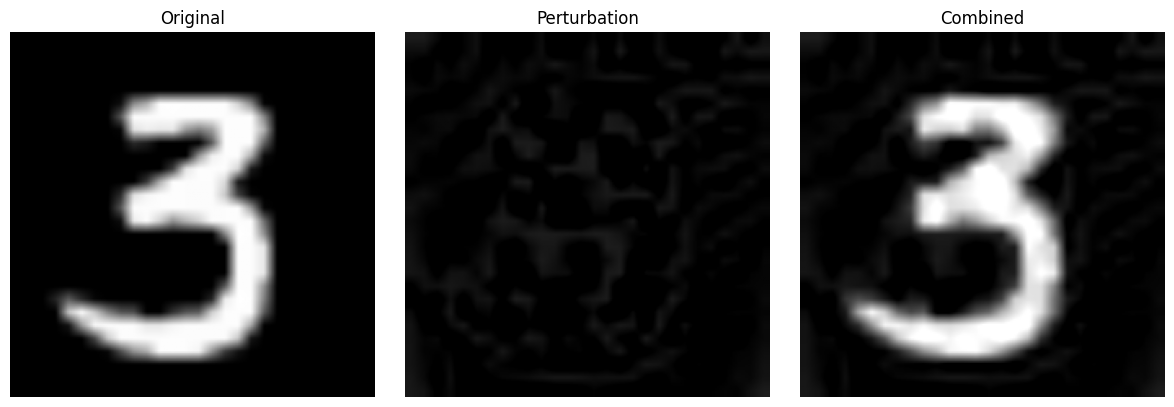

torch.Size([1, 1, 28, 28]) torch.Size([1, 3, 224, 224]) torch.Size([])
Step 0, Loss: 6.2900, Predicted: 8
Step 2, Loss: 6.1757, Predicted: 8
Step 4, Loss: 6.0480, Predicted: 8
Step 6, Loss: 5.9103, Predicted: 8
Step 8, Loss: 5.7572, Predicted: 8
Step 10, Loss: 5.5790, Predicted: 8
Step 12, Loss: 5.3781, Predicted: 8
Step 14, Loss: 5.1561, Predicted: 8
Step 16, Loss: 4.9077, Predicted: 8
Step 18, Loss: 4.6180, Predicted: 8
Step 20, Loss: 4.2610, Predicted: 8
Step 22, Loss: 3.8752, Predicted: 8
Step 24, Loss: 3.4567, Predicted: 8
Step 26, Loss: 2.9933, Predicted: 8
Step 28, Loss: 2.4848, Predicted: 8
Step 30, Loss: 1.9484, Predicted: 8
Step 32, Loss: 1.4115, Predicted: 8
Step 34, Loss: 0.9235, Predicted: 8
SUCCESS!!!! 3
0.00036898057


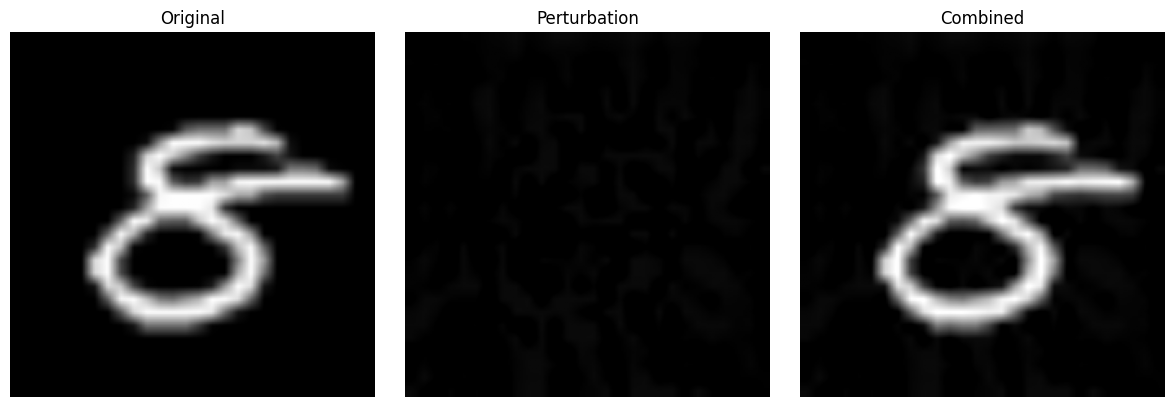

torch.Size([1, 1, 28, 28]) torch.Size([1, 3, 224, 224]) torch.Size([])
Step 0, Loss: 7.8568, Predicted: 3
Step 2, Loss: 7.8397, Predicted: 3
Step 4, Loss: 7.8224, Predicted: 3
Step 6, Loss: 7.8033, Predicted: 3
Step 8, Loss: 7.7810, Predicted: 3
Step 10, Loss: 7.7564, Predicted: 3
Step 12, Loss: 7.7295, Predicted: 3
Step 14, Loss: 7.7000, Predicted: 3
Step 16, Loss: 7.6677, Predicted: 3
Step 18, Loss: 7.6344, Predicted: 3
Step 20, Loss: 7.5996, Predicted: 3
Step 22, Loss: 7.5645, Predicted: 3
Step 24, Loss: 7.5281, Predicted: 3
Step 26, Loss: 7.4893, Predicted: 3
Step 28, Loss: 7.4487, Predicted: 3
Step 30, Loss: 7.4046, Predicted: 3
Step 32, Loss: 7.3556, Predicted: 3
Step 34, Loss: 7.3010, Predicted: 3
Step 36, Loss: 7.2396, Predicted: 3
Step 38, Loss: 7.1736, Predicted: 3
Step 40, Loss: 7.1068, Predicted: 3
Step 42, Loss: 7.0309, Predicted: 3
Step 44, Loss: 6.9482, Predicted: 3
Step 46, Loss: 6.8494, Predicted: 3
Step 48, Loss: 6.7290, Predicted: 3
Step 50, Loss: 6.5920, Predicted: 

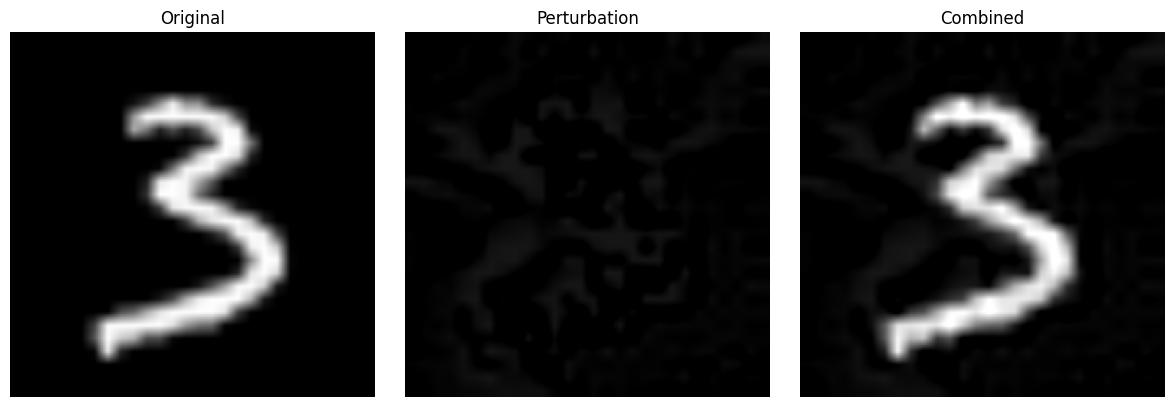

torch.Size([1, 1, 28, 28]) torch.Size([1, 3, 224, 224]) torch.Size([])
Step 0, Loss: 7.4799, Predicted: 8
Step 2, Loss: 7.4370, Predicted: 8
Step 4, Loss: 7.3897, Predicted: 8
Step 6, Loss: 7.3364, Predicted: 8
Step 8, Loss: 7.2745, Predicted: 8
Step 10, Loss: 7.2054, Predicted: 8
Step 12, Loss: 7.1305, Predicted: 8
Step 14, Loss: 7.0511, Predicted: 8
Step 16, Loss: 6.9664, Predicted: 8
Step 18, Loss: 6.8731, Predicted: 8
Step 20, Loss: 6.7687, Predicted: 8
Step 22, Loss: 6.6494, Predicted: 8
Step 24, Loss: 6.5116, Predicted: 8
Step 26, Loss: 6.3445, Predicted: 8
Step 28, Loss: 6.1416, Predicted: 8
Step 30, Loss: 5.8939, Predicted: 8
Step 32, Loss: 5.5798, Predicted: 8
Step 34, Loss: 5.1659, Predicted: 8
Step 36, Loss: 4.6231, Predicted: 8
Step 38, Loss: 3.9199, Predicted: 8
Step 40, Loss: 3.0396, Predicted: 8
Step 42, Loss: 1.9943, Predicted: 8
Step 44, Loss: 0.9820, Predicted: 8
SUCCESS!!!! 3
0.0006612646


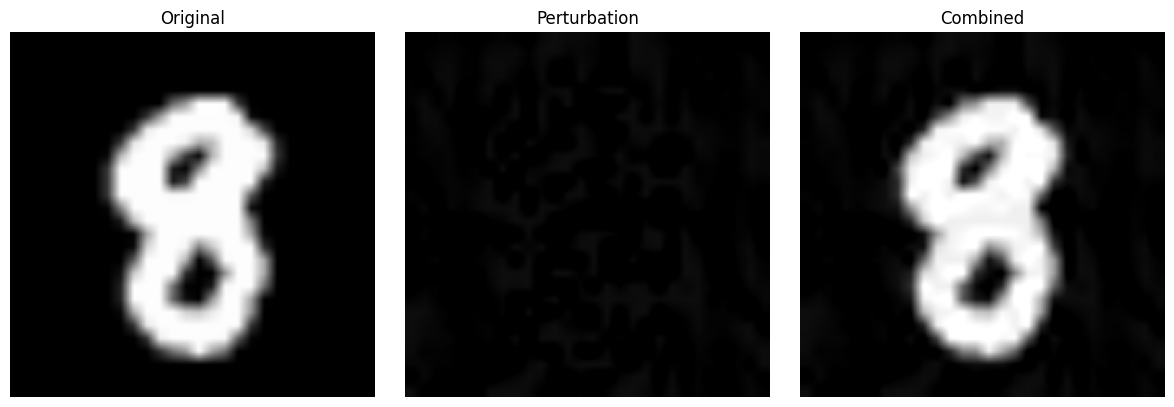

torch.Size([1, 1, 28, 28]) torch.Size([1, 3, 224, 224]) torch.Size([])
Step 0, Loss: 7.6925, Predicted: 8
Step 2, Loss: 7.6716, Predicted: 8
Step 4, Loss: 7.6473, Predicted: 8
Step 6, Loss: 7.6234, Predicted: 8
Step 8, Loss: 7.5977, Predicted: 8
Step 10, Loss: 7.5676, Predicted: 8
Step 12, Loss: 7.5349, Predicted: 8
Step 14, Loss: 7.4986, Predicted: 8
Step 16, Loss: 7.4606, Predicted: 8
Step 18, Loss: 7.4183, Predicted: 8
Step 20, Loss: 7.3742, Predicted: 8
Step 22, Loss: 7.3287, Predicted: 8
Step 24, Loss: 7.2811, Predicted: 8
Step 26, Loss: 7.2284, Predicted: 8
Step 28, Loss: 7.1690, Predicted: 8
Step 30, Loss: 7.1003, Predicted: 8
Step 32, Loss: 7.0191, Predicted: 8
Step 34, Loss: 6.9155, Predicted: 8
Step 36, Loss: 6.7865, Predicted: 8
Step 38, Loss: 6.6092, Predicted: 8
Step 40, Loss: 6.3479, Predicted: 8
Step 42, Loss: 5.9494, Predicted: 8
Step 44, Loss: 5.3268, Predicted: 8
Step 46, Loss: 4.3417, Predicted: 8
Step 48, Loss: 2.9023, Predicted: 8
Step 50, Loss: 1.1505, Predicted: 

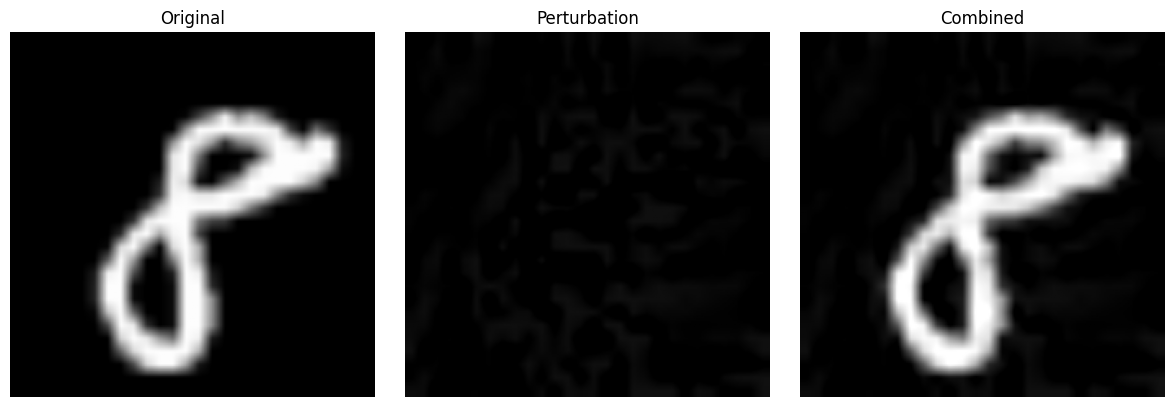

torch.Size([1, 1, 28, 28]) torch.Size([1, 3, 224, 224]) torch.Size([])
Step 0, Loss: 7.7988, Predicted: 3
Step 2, Loss: 7.7708, Predicted: 3
Step 4, Loss: 7.7386, Predicted: 3
Step 6, Loss: 7.7029, Predicted: 3
Step 8, Loss: 7.6625, Predicted: 3
Step 10, Loss: 7.6163, Predicted: 3
Step 12, Loss: 7.5642, Predicted: 3
Step 14, Loss: 7.5073, Predicted: 3
Step 16, Loss: 7.4461, Predicted: 3
Step 18, Loss: 7.3820, Predicted: 3
Step 20, Loss: 7.3080, Predicted: 3
Step 22, Loss: 7.2240, Predicted: 3
Step 24, Loss: 7.1270, Predicted: 3
Step 26, Loss: 7.0122, Predicted: 3
Step 28, Loss: 6.8644, Predicted: 3
Step 30, Loss: 6.6780, Predicted: 3
Step 32, Loss: 6.4301, Predicted: 3
Step 34, Loss: 6.0930, Predicted: 3
Step 36, Loss: 5.6126, Predicted: 3
Step 38, Loss: 4.8846, Predicted: 3
Step 40, Loss: 3.8077, Predicted: 3
Step 42, Loss: 2.3582, Predicted: 3
Step 44, Loss: 1.0444, Predicted: 3
SUCCESS!!!! 8
0.00070896675


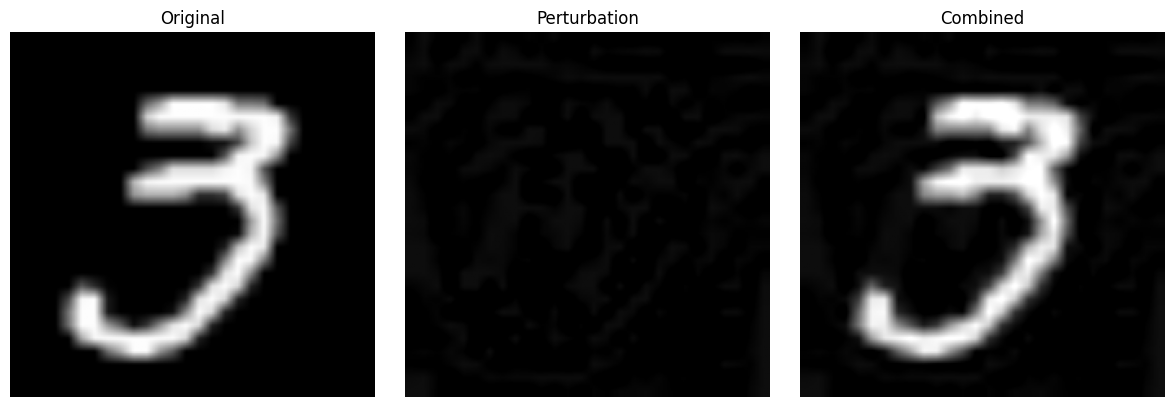

torch.Size([1, 1, 28, 28]) torch.Size([1, 3, 224, 224]) torch.Size([])
Step 0, Loss: 7.4958, Predicted: 8
Step 2, Loss: 7.4593, Predicted: 8
Step 4, Loss: 7.4163, Predicted: 8
Step 6, Loss: 7.3665, Predicted: 8
Step 8, Loss: 7.3092, Predicted: 8
Step 10, Loss: 7.2392, Predicted: 8
Step 12, Loss: 7.1546, Predicted: 8
Step 14, Loss: 7.0556, Predicted: 8
Step 16, Loss: 6.9426, Predicted: 8
Step 18, Loss: 6.8141, Predicted: 8
Step 20, Loss: 6.6661, Predicted: 8
Step 22, Loss: 6.4986, Predicted: 8
Step 24, Loss: 6.2971, Predicted: 8
Step 26, Loss: 6.0474, Predicted: 8
Step 28, Loss: 5.7287, Predicted: 8
Step 30, Loss: 5.3129, Predicted: 8
Step 32, Loss: 4.7572, Predicted: 8
Step 34, Loss: 3.9860, Predicted: 8
Step 36, Loss: 2.9011, Predicted: 8
Step 38, Loss: 1.5451, Predicted: 8
SUCCESS!!!! 3
0.00054928893


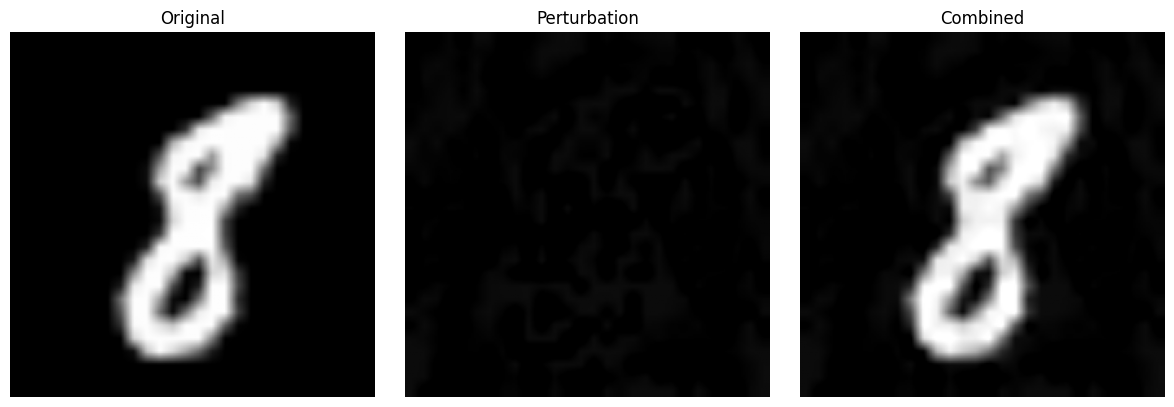

torch.Size([1, 1, 28, 28]) torch.Size([1, 3, 224, 224]) torch.Size([])
Step 0, Loss: 7.5523, Predicted: 8
Step 2, Loss: 7.5303, Predicted: 8
Step 4, Loss: 7.5056, Predicted: 8
Step 6, Loss: 7.4790, Predicted: 8
Step 8, Loss: 7.4497, Predicted: 8
Step 10, Loss: 7.4167, Predicted: 8
Step 12, Loss: 7.3797, Predicted: 8
Step 14, Loss: 7.3401, Predicted: 8
Step 16, Loss: 7.2968, Predicted: 8
Step 18, Loss: 7.2495, Predicted: 8
Step 20, Loss: 7.1980, Predicted: 8
Step 22, Loss: 7.1434, Predicted: 8
Step 24, Loss: 7.0857, Predicted: 8
Step 26, Loss: 7.0259, Predicted: 8
Step 28, Loss: 6.9574, Predicted: 8
Step 30, Loss: 6.8875, Predicted: 8
Step 32, Loss: 6.8176, Predicted: 8
Step 34, Loss: 6.7441, Predicted: 8
Step 36, Loss: 6.6663, Predicted: 8
Step 38, Loss: 6.5811, Predicted: 8
Step 40, Loss: 6.4851, Predicted: 8
Step 42, Loss: 6.3740, Predicted: 8
Step 44, Loss: 6.2439, Predicted: 8
Step 46, Loss: 6.0895, Predicted: 8
Step 48, Loss: 5.8915, Predicted: 8
Step 50, Loss: 5.6311, Predicted: 

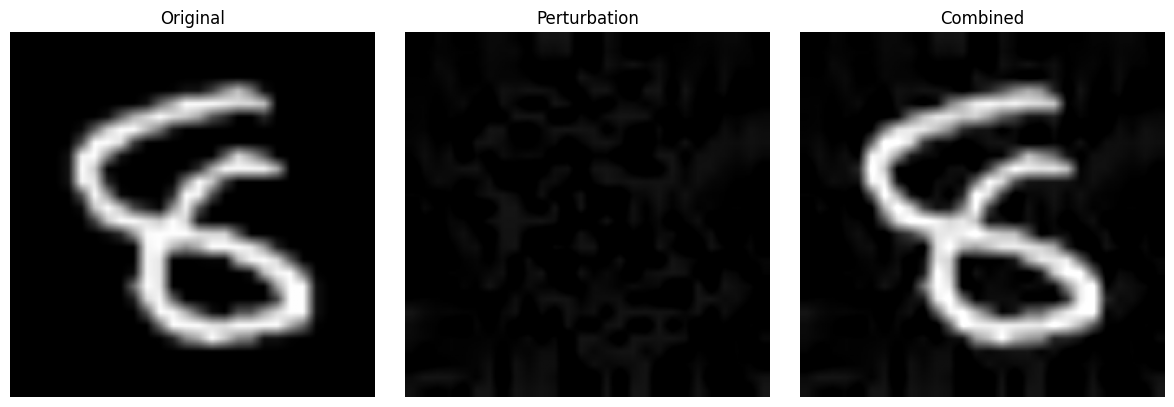

torch.Size([1, 1, 28, 28]) torch.Size([1, 3, 224, 224]) torch.Size([])
Step 0, Loss: 7.3809, Predicted: 8
Step 2, Loss: 7.3527, Predicted: 8
Step 4, Loss: 7.3212, Predicted: 8
Step 6, Loss: 7.2872, Predicted: 8
Step 8, Loss: 7.2515, Predicted: 8
Step 10, Loss: 7.2114, Predicted: 8
Step 12, Loss: 7.1678, Predicted: 8
Step 14, Loss: 7.1197, Predicted: 8
Step 16, Loss: 7.0670, Predicted: 8
Step 18, Loss: 7.0082, Predicted: 8
Step 20, Loss: 6.9425, Predicted: 8
Step 22, Loss: 6.8681, Predicted: 8
Step 24, Loss: 6.7841, Predicted: 8
Step 26, Loss: 6.6897, Predicted: 8
Step 28, Loss: 6.5814, Predicted: 8
Step 30, Loss: 6.4510, Predicted: 8
Step 32, Loss: 6.2885, Predicted: 8
Step 34, Loss: 6.0845, Predicted: 8
Step 36, Loss: 5.8143, Predicted: 8
Step 38, Loss: 5.4347, Predicted: 8
Step 40, Loss: 4.8815, Predicted: 8
Step 42, Loss: 4.0655, Predicted: 8
Step 44, Loss: 2.9105, Predicted: 8
Step 46, Loss: 1.4932, Predicted: 8
SUCCESS!!!! 3
0.000694739


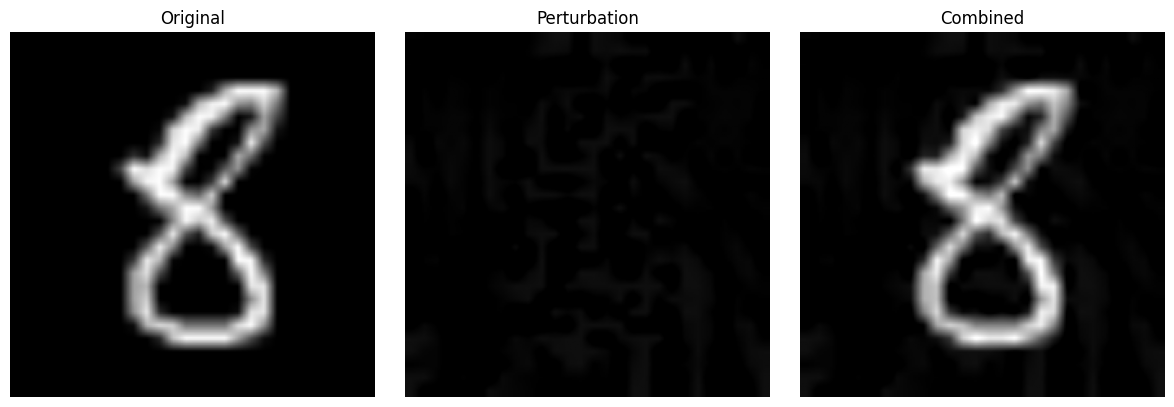

torch.Size([1, 1, 28, 28]) torch.Size([1, 3, 224, 224]) torch.Size([])
Step 0, Loss: 7.9904, Predicted: 3
Step 2, Loss: 7.9710, Predicted: 3
Step 4, Loss: 7.9537, Predicted: 3
Step 6, Loss: 7.9332, Predicted: 3
Step 8, Loss: 7.9107, Predicted: 3
Step 10, Loss: 7.8846, Predicted: 3
Step 12, Loss: 7.8604, Predicted: 3
Step 14, Loss: 7.8312, Predicted: 3
Step 16, Loss: 7.8017, Predicted: 3
Step 18, Loss: 7.7710, Predicted: 3
Step 20, Loss: 7.7387, Predicted: 3
Step 22, Loss: 7.7047, Predicted: 3
Step 24, Loss: 7.6684, Predicted: 3
Step 26, Loss: 7.6282, Predicted: 3
Step 28, Loss: 7.5848, Predicted: 3
Step 30, Loss: 7.5308, Predicted: 3
Step 32, Loss: 7.4663, Predicted: 3
Step 34, Loss: 7.3859, Predicted: 3
Step 36, Loss: 7.2940, Predicted: 3
Step 38, Loss: 7.1892, Predicted: 3
Step 40, Loss: 7.0711, Predicted: 3
Step 42, Loss: 6.9367, Predicted: 3
Step 44, Loss: 6.7858, Predicted: 3
Step 46, Loss: 6.6140, Predicted: 3
Step 48, Loss: 6.4196, Predicted: 3
Step 50, Loss: 6.1940, Predicted: 

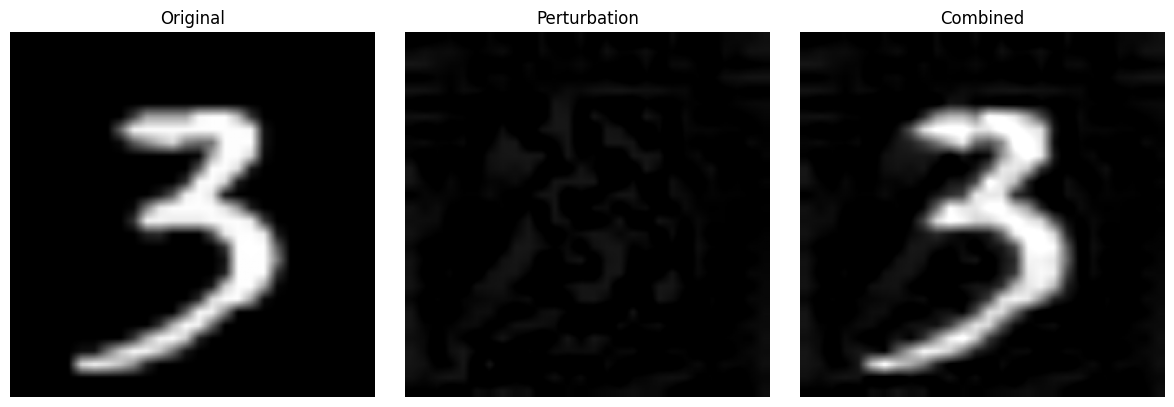

torch.Size([1, 1, 28, 28]) torch.Size([1, 3, 224, 224]) torch.Size([])
Step 0, Loss: 7.6576, Predicted: 3
Step 2, Loss: 7.6212, Predicted: 3
Step 4, Loss: 7.5798, Predicted: 3
Step 6, Loss: 7.5333, Predicted: 3
Step 8, Loss: 7.4799, Predicted: 3
Step 10, Loss: 7.4185, Predicted: 3
Step 12, Loss: 7.3473, Predicted: 3
Step 14, Loss: 7.2627, Predicted: 3
Step 16, Loss: 7.1666, Predicted: 3
Step 18, Loss: 7.0472, Predicted: 3
Step 20, Loss: 6.9020, Predicted: 3
Step 22, Loss: 6.7226, Predicted: 3
Step 24, Loss: 6.4956, Predicted: 3
Step 26, Loss: 6.2007, Predicted: 3
Step 28, Loss: 5.8032, Predicted: 3
Step 30, Loss: 5.2694, Predicted: 3
Step 32, Loss: 4.5031, Predicted: 3
Step 34, Loss: 3.5717, Predicted: 3
Step 36, Loss: 2.7855, Predicted: 3
Step 38, Loss: 2.2586, Predicted: 5
Step 40, Loss: 1.7971, Predicted: 5
Step 42, Loss: 1.2466, Predicted: 5
SUCCESS!!!! 8
0.00064944505


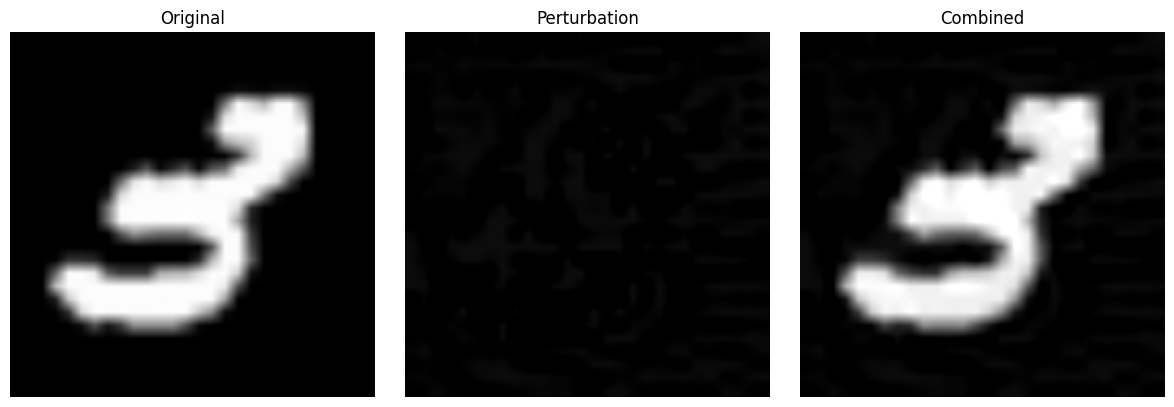

torch.Size([1, 1, 28, 28]) torch.Size([1, 3, 224, 224]) torch.Size([])
Step 0, Loss: 7.6564, Predicted: 8
Step 2, Loss: 7.6311, Predicted: 8
Step 4, Loss: 7.6040, Predicted: 8
Step 6, Loss: 7.5743, Predicted: 8
Step 8, Loss: 7.5403, Predicted: 8
Step 10, Loss: 7.5008, Predicted: 8
Step 12, Loss: 7.4556, Predicted: 8
Step 14, Loss: 7.4054, Predicted: 8
Step 16, Loss: 7.3510, Predicted: 8
Step 18, Loss: 7.2934, Predicted: 8
Step 20, Loss: 7.2317, Predicted: 8
Step 22, Loss: 7.1654, Predicted: 8
Step 24, Loss: 7.0921, Predicted: 8
Step 26, Loss: 7.0091, Predicted: 8
Step 28, Loss: 6.9127, Predicted: 8
Step 30, Loss: 6.7990, Predicted: 8
Step 32, Loss: 6.6576, Predicted: 8
Step 34, Loss: 6.4714, Predicted: 8
Step 36, Loss: 6.2115, Predicted: 8
Step 38, Loss: 5.8244, Predicted: 8
Step 40, Loss: 5.2086, Predicted: 8
Step 42, Loss: 4.1867, Predicted: 8
Step 44, Loss: 2.5901, Predicted: 8
Step 46, Loss: 0.7784, Predicted: 8
SUCCESS!!!! 3
0.00075527374


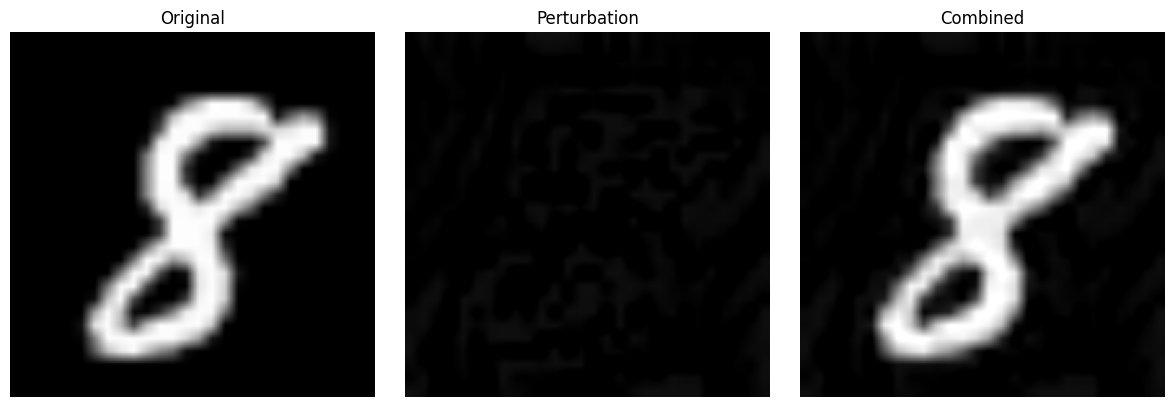

torch.Size([1, 1, 28, 28]) torch.Size([1, 3, 224, 224]) torch.Size([])
Step 0, Loss: 7.6583, Predicted: 8
Step 2, Loss: 7.6310, Predicted: 8
Step 4, Loss: 7.6008, Predicted: 8
Step 6, Loss: 7.5675, Predicted: 8
Step 8, Loss: 7.5282, Predicted: 8
Step 10, Loss: 7.4813, Predicted: 8
Step 12, Loss: 7.4265, Predicted: 8
Step 14, Loss: 7.3657, Predicted: 8
Step 16, Loss: 7.2999, Predicted: 8
Step 18, Loss: 7.2277, Predicted: 8
Step 20, Loss: 7.1480, Predicted: 8
Step 22, Loss: 7.0604, Predicted: 8
Step 24, Loss: 6.9631, Predicted: 8
Step 26, Loss: 6.8529, Predicted: 8
Step 28, Loss: 6.7266, Predicted: 8
Step 30, Loss: 6.5767, Predicted: 8
Step 32, Loss: 6.3910, Predicted: 8
Step 34, Loss: 6.1501, Predicted: 8
Step 36, Loss: 5.8263, Predicted: 8
Step 38, Loss: 5.3864, Predicted: 8
Step 40, Loss: 4.7885, Predicted: 8
Step 42, Loss: 3.9851, Predicted: 8
Step 44, Loss: 2.9354, Predicted: 8
Step 46, Loss: 1.6618, Predicted: 8
SUCCESS!!!! 3
0.00078061206


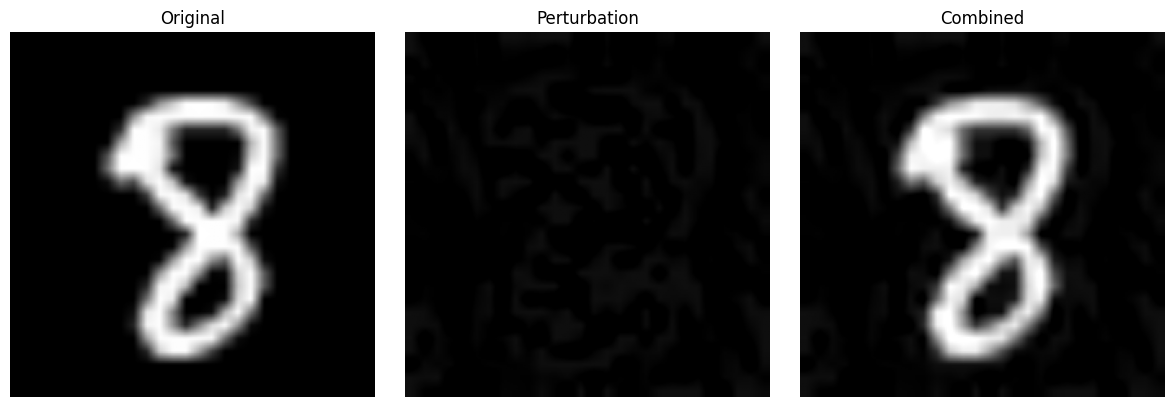

torch.Size([1, 1, 28, 28]) torch.Size([1, 3, 224, 224]) torch.Size([])
Step 0, Loss: 7.8757, Predicted: 3
Step 2, Loss: 7.8581, Predicted: 3
Step 4, Loss: 7.8342, Predicted: 3
Step 6, Loss: 7.8097, Predicted: 3
Step 8, Loss: 7.7786, Predicted: 3
Step 10, Loss: 7.7408, Predicted: 3
Step 12, Loss: 7.6986, Predicted: 3
Step 14, Loss: 7.6593, Predicted: 3
Step 16, Loss: 7.6111, Predicted: 3
Step 18, Loss: 7.5594, Predicted: 3
Step 20, Loss: 7.5034, Predicted: 3
Step 22, Loss: 7.4451, Predicted: 3
Step 24, Loss: 7.3725, Predicted: 3
Step 26, Loss: 7.2846, Predicted: 3
Step 28, Loss: 7.1733, Predicted: 3
Step 30, Loss: 7.0448, Predicted: 3
Step 32, Loss: 6.8746, Predicted: 3
Step 34, Loss: 6.6490, Predicted: 3
Step 36, Loss: 6.3511, Predicted: 3
Step 38, Loss: 5.9619, Predicted: 3
Step 40, Loss: 5.4376, Predicted: 3
Step 42, Loss: 4.7460, Predicted: 3
Step 44, Loss: 3.8388, Predicted: 3
Step 46, Loss: 2.8642, Predicted: 3
Step 48, Loss: 2.0005, Predicted: 3
Step 50, Loss: 1.3767, Predicted: 

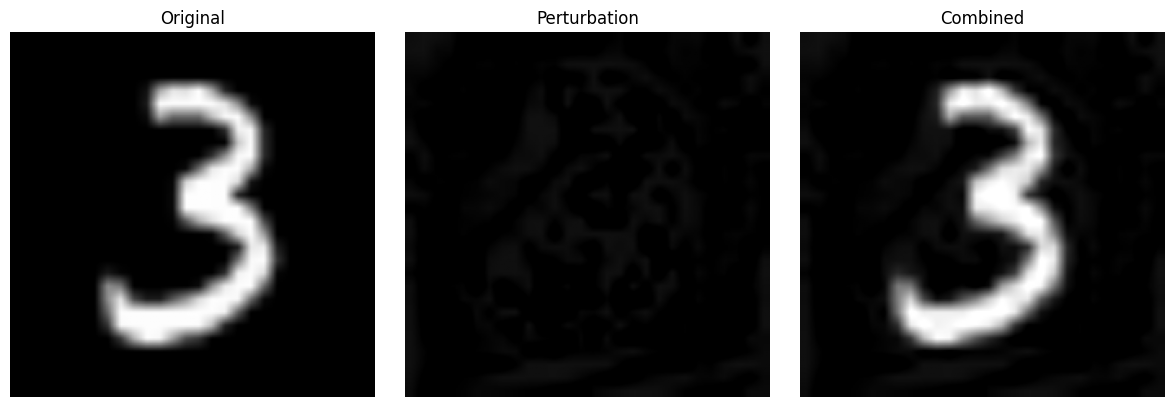

torch.Size([1, 1, 28, 28]) torch.Size([1, 3, 224, 224]) torch.Size([])
Step 0, Loss: 6.8441, Predicted: 8
Step 2, Loss: 6.7746, Predicted: 8
Step 4, Loss: 6.6939, Predicted: 8
Step 6, Loss: 6.6004, Predicted: 8
Step 8, Loss: 6.4950, Predicted: 8
Step 10, Loss: 6.3728, Predicted: 8
Step 12, Loss: 6.2262, Predicted: 8
Step 14, Loss: 6.0511, Predicted: 8
Step 16, Loss: 5.8354, Predicted: 8
Step 18, Loss: 5.5678, Predicted: 8
Step 20, Loss: 5.2305, Predicted: 8
Step 22, Loss: 4.8083, Predicted: 8
Step 24, Loss: 4.2871, Predicted: 8
Step 26, Loss: 3.6426, Predicted: 8
Step 28, Loss: 2.8673, Predicted: 8
Step 30, Loss: 1.9967, Predicted: 8
Step 32, Loss: 1.1493, Predicted: 8
SUCCESS!!!! 3
0.00044253553


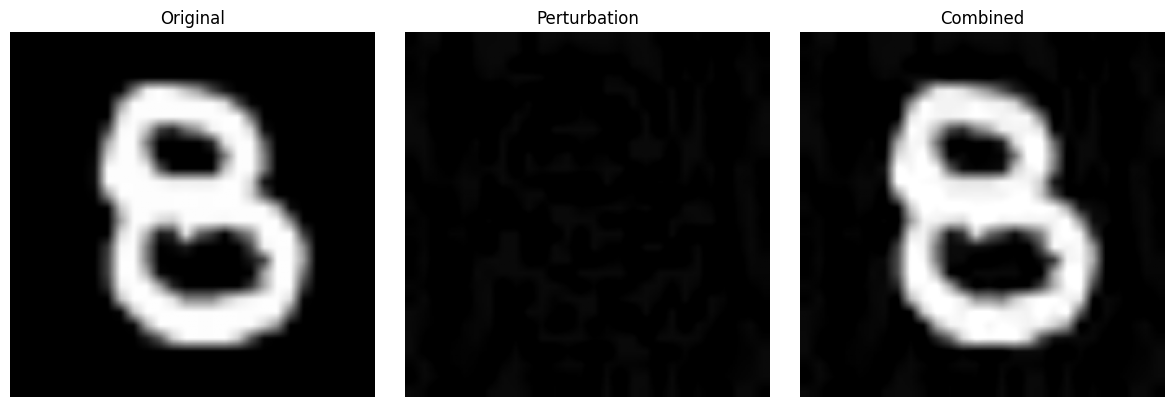

torch.Size([1, 1, 28, 28]) torch.Size([1, 3, 224, 224]) torch.Size([])
Step 0, Loss: 7.6090, Predicted: 8
Step 2, Loss: 7.5859, Predicted: 8
Step 4, Loss: 7.5599, Predicted: 8
Step 6, Loss: 7.5309, Predicted: 8
Step 8, Loss: 7.4972, Predicted: 8
Step 10, Loss: 7.4580, Predicted: 8
Step 12, Loss: 7.4136, Predicted: 8
Step 14, Loss: 7.3643, Predicted: 8
Step 16, Loss: 7.3095, Predicted: 8
Step 18, Loss: 7.2497, Predicted: 8
Step 20, Loss: 7.1843, Predicted: 8
Step 22, Loss: 7.1125, Predicted: 8
Step 24, Loss: 7.0331, Predicted: 8
Step 26, Loss: 6.9464, Predicted: 8
Step 28, Loss: 6.8454, Predicted: 8
Step 30, Loss: 6.7349, Predicted: 8
Step 32, Loss: 6.6086, Predicted: 8
Step 34, Loss: 6.4636, Predicted: 8
Step 36, Loss: 6.2909, Predicted: 8
Step 38, Loss: 6.0869, Predicted: 8
Step 40, Loss: 5.8392, Predicted: 8
Step 42, Loss: 5.5237, Predicted: 8
Step 44, Loss: 5.1007, Predicted: 8
Step 46, Loss: 4.5163, Predicted: 8
Step 48, Loss: 3.7290, Predicted: 8
Step 50, Loss: 2.7103, Predicted: 

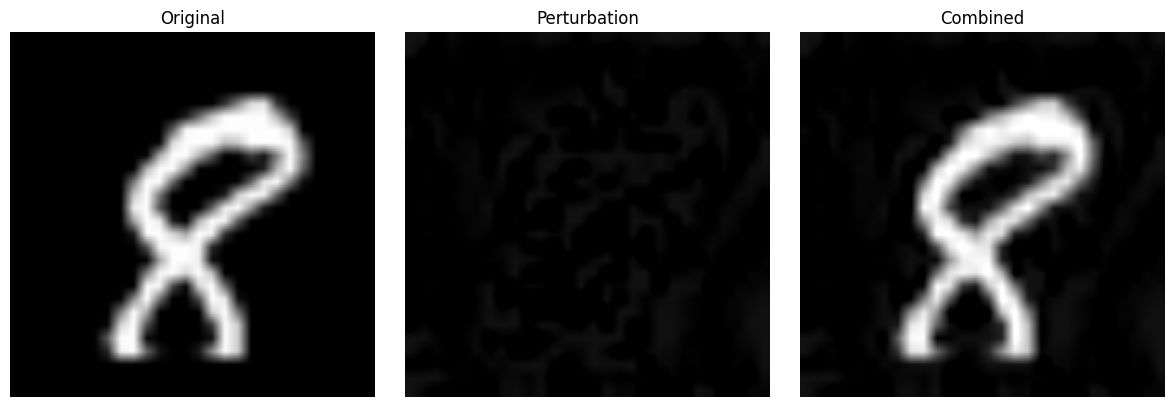

torch.Size([1, 1, 28, 28]) torch.Size([1, 3, 224, 224]) torch.Size([])
Step 0, Loss: 7.1203, Predicted: 3
Step 2, Loss: 7.0354, Predicted: 3
Step 4, Loss: 6.9384, Predicted: 3
Step 6, Loss: 6.8266, Predicted: 3
Step 8, Loss: 6.6956, Predicted: 3
Step 10, Loss: 6.5366, Predicted: 3
Step 12, Loss: 6.3456, Predicted: 3
Step 14, Loss: 6.1226, Predicted: 3
Step 16, Loss: 5.8571, Predicted: 3
Step 18, Loss: 5.5398, Predicted: 3
Step 20, Loss: 5.1618, Predicted: 3
Step 22, Loss: 4.7063, Predicted: 3
Step 24, Loss: 4.1468, Predicted: 3
Step 26, Loss: 3.4786, Predicted: 3
Step 28, Loss: 2.7470, Predicted: 3
Step 30, Loss: 1.9345, Predicted: 3
Step 32, Loss: 1.1846, Predicted: 3
SUCCESS!!!! 8
0.00037452177


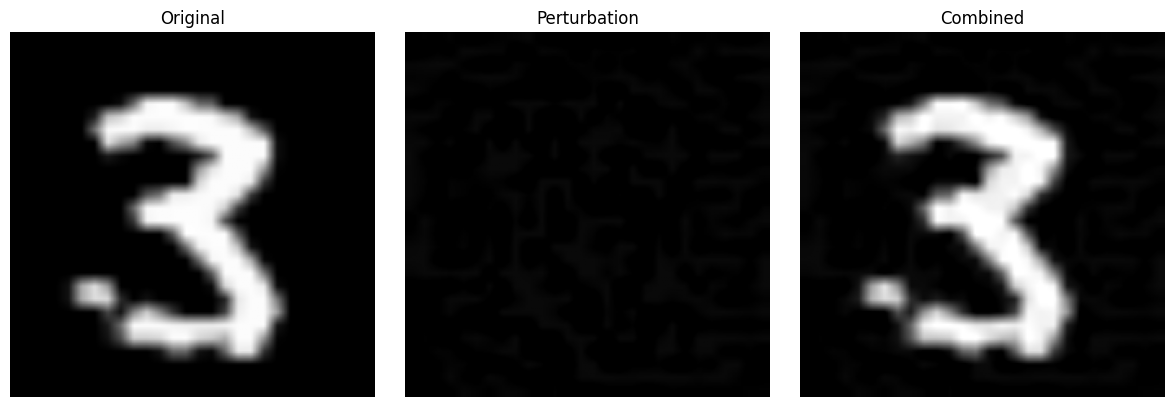

torch.Size([1, 1, 28, 28]) torch.Size([1, 3, 224, 224]) torch.Size([])
Step 0, Loss: 8.0062, Predicted: 3
Step 2, Loss: 7.9894, Predicted: 3
Step 4, Loss: 7.9676, Predicted: 3
Step 6, Loss: 7.9439, Predicted: 3
Step 8, Loss: 7.9174, Predicted: 3
Step 10, Loss: 7.8867, Predicted: 3
Step 12, Loss: 7.8522, Predicted: 3
Step 14, Loss: 7.8121, Predicted: 3
Step 16, Loss: 7.7682, Predicted: 3
Step 18, Loss: 7.7224, Predicted: 3
Step 20, Loss: 7.6756, Predicted: 3
Step 22, Loss: 7.6237, Predicted: 3
Step 24, Loss: 7.5671, Predicted: 3
Step 26, Loss: 7.5037, Predicted: 3
Step 28, Loss: 7.4375, Predicted: 3
Step 30, Loss: 7.3622, Predicted: 3
Step 32, Loss: 7.2768, Predicted: 3
Step 34, Loss: 7.1833, Predicted: 3
Step 36, Loss: 7.0794, Predicted: 3
Step 38, Loss: 6.9565, Predicted: 3
Step 40, Loss: 6.8196, Predicted: 3
Step 42, Loss: 6.6485, Predicted: 3
Step 44, Loss: 6.4393, Predicted: 3
Step 46, Loss: 6.1749, Predicted: 3
Step 48, Loss: 5.8239, Predicted: 3
Step 50, Loss: 5.3720, Predicted: 

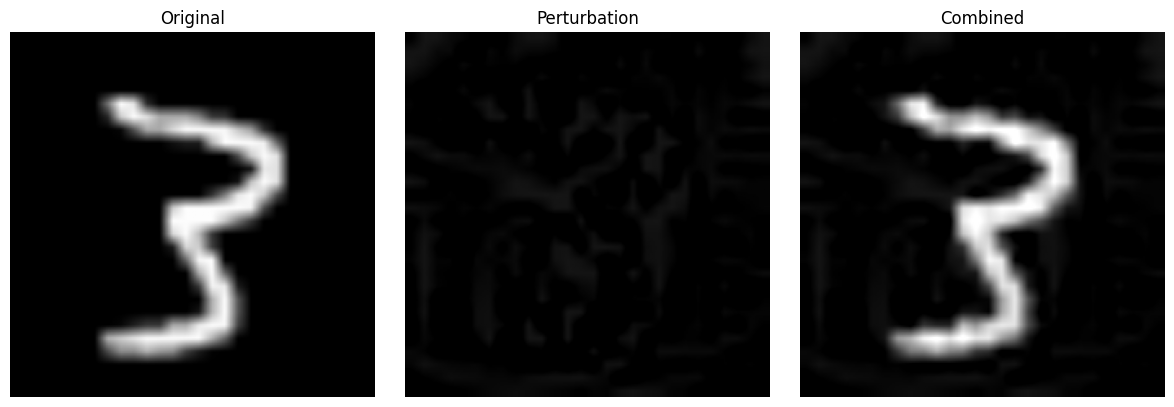

torch.Size([1, 1, 28, 28]) torch.Size([1, 3, 224, 224]) torch.Size([])
Step 0, Loss: 6.7709, Predicted: 8
Step 2, Loss: 6.6633, Predicted: 8
Step 4, Loss: 6.5371, Predicted: 8
Step 6, Loss: 6.3950, Predicted: 8
Step 8, Loss: 6.2276, Predicted: 8
Step 10, Loss: 6.0298, Predicted: 8
Step 12, Loss: 5.7895, Predicted: 8
Step 14, Loss: 5.4983, Predicted: 8
Step 16, Loss: 5.1483, Predicted: 8
Step 18, Loss: 4.7337, Predicted: 8
Step 20, Loss: 4.2498, Predicted: 8
Step 22, Loss: 3.6897, Predicted: 8
Step 24, Loss: 3.0493, Predicted: 8
Step 26, Loss: 2.3418, Predicted: 8
Step 28, Loss: 1.6052, Predicted: 8
Step 30, Loss: 0.9161, Predicted: 8
SUCCESS!!!! 3
0.0003320104


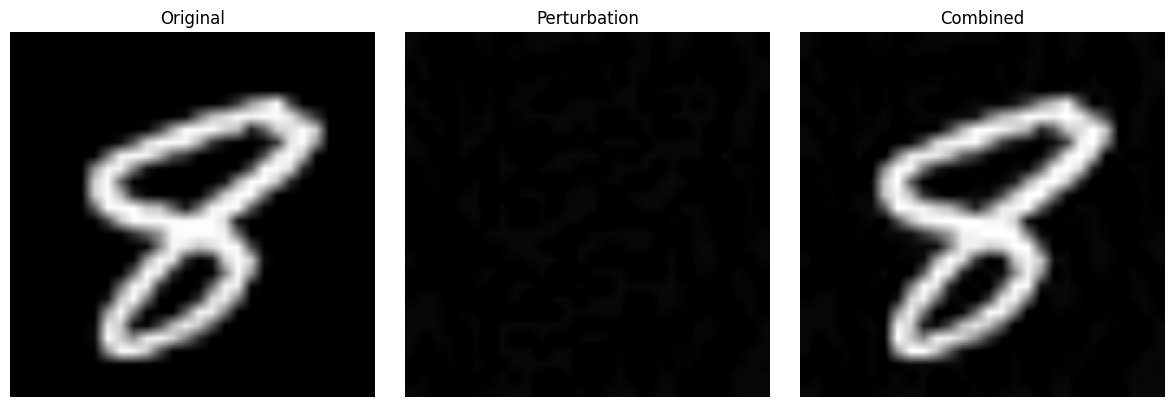

torch.Size([1, 1, 28, 28]) torch.Size([1, 3, 224, 224]) torch.Size([])
Step 0, Loss: 7.3102, Predicted: 8
Step 2, Loss: 7.2823, Predicted: 8
Step 4, Loss: 7.2515, Predicted: 8
Step 6, Loss: 7.2202, Predicted: 8
Step 8, Loss: 7.1855, Predicted: 8
Step 10, Loss: 7.1477, Predicted: 8
Step 12, Loss: 7.1053, Predicted: 8
Step 14, Loss: 7.0579, Predicted: 8
Step 16, Loss: 7.0056, Predicted: 8
Step 18, Loss: 6.9483, Predicted: 8
Step 20, Loss: 6.8859, Predicted: 8
Step 22, Loss: 6.8182, Predicted: 8
Step 24, Loss: 6.7445, Predicted: 8
Step 26, Loss: 6.6637, Predicted: 8
Step 28, Loss: 6.5755, Predicted: 8
Step 30, Loss: 6.4793, Predicted: 8
Step 32, Loss: 6.3722, Predicted: 8
Step 34, Loss: 6.2507, Predicted: 8
Step 36, Loss: 6.1119, Predicted: 8
Step 38, Loss: 5.9506, Predicted: 8
Step 40, Loss: 5.7616, Predicted: 8
Step 42, Loss: 5.5359, Predicted: 8
Step 44, Loss: 5.2584, Predicted: 8
Step 46, Loss: 4.9052, Predicted: 8
Step 48, Loss: 4.4377, Predicted: 8
Step 50, Loss: 3.7974, Predicted: 

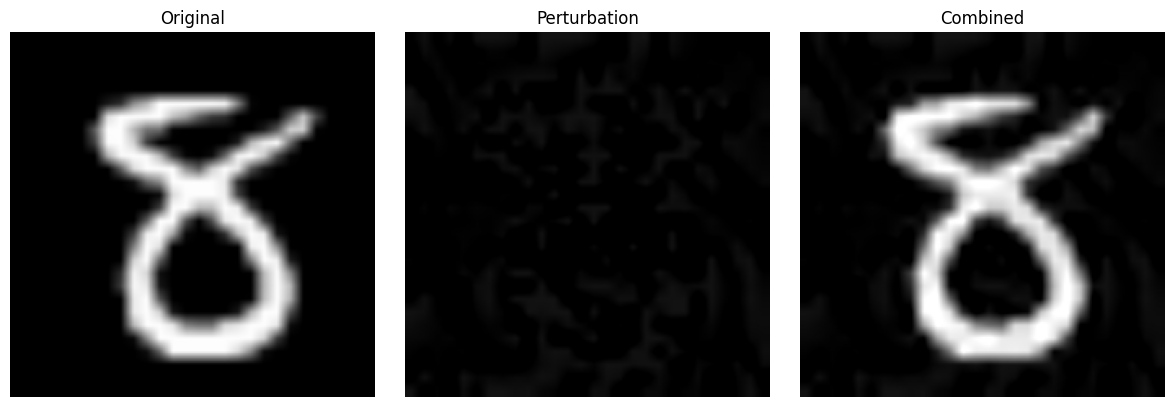

torch.Size([1, 1, 28, 28]) torch.Size([1, 3, 224, 224]) torch.Size([])
Step 0, Loss: 7.9067, Predicted: 3
Step 2, Loss: 7.8868, Predicted: 3
Step 4, Loss: 7.8641, Predicted: 3
Step 6, Loss: 7.8407, Predicted: 3
Step 8, Loss: 7.8172, Predicted: 3
Step 10, Loss: 7.7912, Predicted: 3
Step 12, Loss: 7.7616, Predicted: 3
Step 14, Loss: 7.7280, Predicted: 3
Step 16, Loss: 7.6908, Predicted: 3
Step 18, Loss: 7.6505, Predicted: 3
Step 20, Loss: 7.6112, Predicted: 3
Step 22, Loss: 7.5675, Predicted: 3
Step 24, Loss: 7.5226, Predicted: 3
Step 26, Loss: 7.4729, Predicted: 3
Step 28, Loss: 7.4185, Predicted: 3
Step 30, Loss: 7.3594, Predicted: 3
Step 32, Loss: 7.2943, Predicted: 3
Step 34, Loss: 7.2225, Predicted: 3
Step 36, Loss: 7.1436, Predicted: 3
Step 38, Loss: 7.0574, Predicted: 3
Step 40, Loss: 6.9635, Predicted: 3
Step 42, Loss: 6.8626, Predicted: 3
Step 44, Loss: 6.7424, Predicted: 3
Step 46, Loss: 6.6152, Predicted: 3
Step 48, Loss: 6.4718, Predicted: 3
Step 50, Loss: 6.2852, Predicted: 

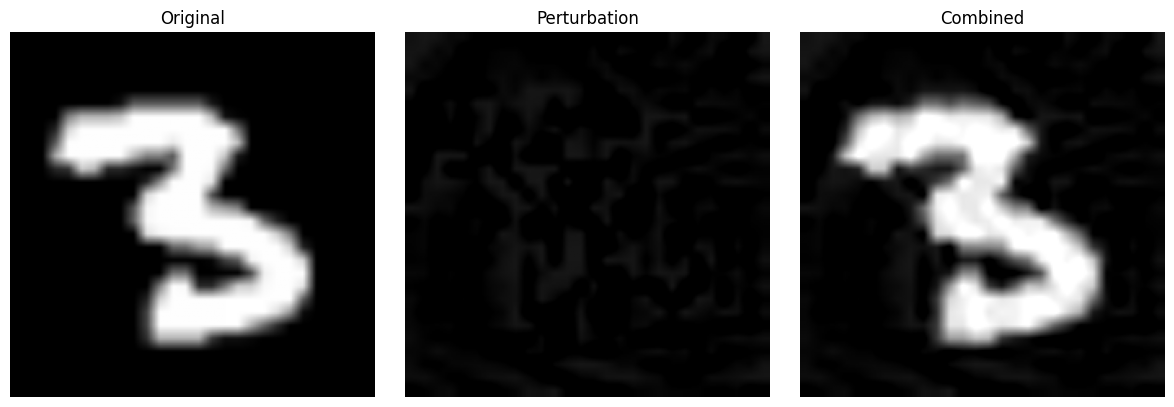

torch.Size([1, 1, 28, 28]) torch.Size([1, 3, 224, 224]) torch.Size([])
Step 0, Loss: 7.6035, Predicted: 3
Step 2, Loss: 7.5661, Predicted: 3
Step 4, Loss: 7.5263, Predicted: 3
Step 6, Loss: 7.4820, Predicted: 3
Step 8, Loss: 7.4341, Predicted: 3
Step 10, Loss: 7.3797, Predicted: 3
Step 12, Loss: 7.3183, Predicted: 3
Step 14, Loss: 7.2503, Predicted: 3
Step 16, Loss: 7.1725, Predicted: 3
Step 18, Loss: 7.0803, Predicted: 3
Step 20, Loss: 6.9733, Predicted: 3
Step 22, Loss: 6.8498, Predicted: 3
Step 24, Loss: 6.7015, Predicted: 3
Step 26, Loss: 6.5231, Predicted: 3
Step 28, Loss: 6.3050, Predicted: 3
Step 30, Loss: 6.0477, Predicted: 3
Step 32, Loss: 5.7439, Predicted: 3
Step 34, Loss: 5.3528, Predicted: 3
Step 36, Loss: 4.8128, Predicted: 3
Step 38, Loss: 4.2240, Predicted: 3
Step 40, Loss: 3.4422, Predicted: 3
Step 42, Loss: 2.5207, Predicted: 3
Step 44, Loss: 1.5173, Predicted: 3
Step 46, Loss: 0.7847, Predicted: 3
SUCCESS!!!! 8
0.0006388116


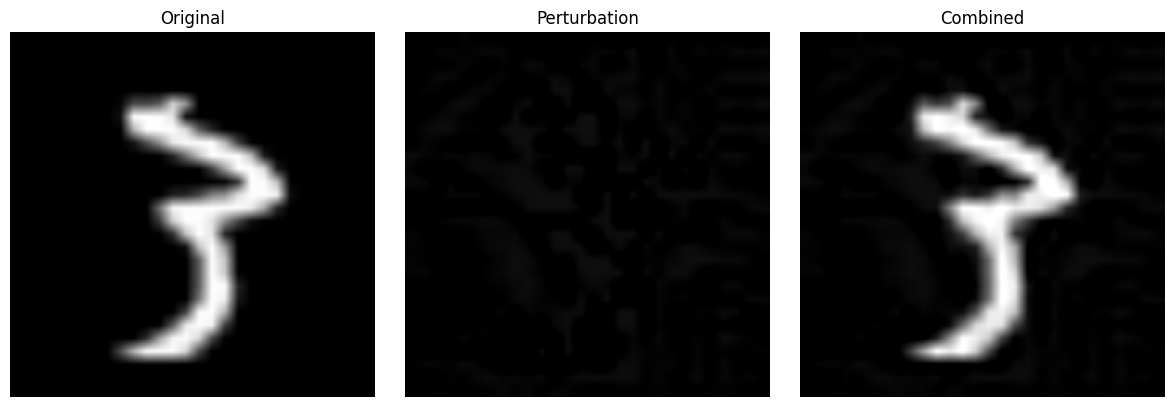

torch.Size([1, 1, 28, 28]) torch.Size([1, 3, 224, 224]) torch.Size([])
Step 0, Loss: 7.5910, Predicted: 3
Step 2, Loss: 7.5596, Predicted: 3
Step 4, Loss: 7.5263, Predicted: 3
Step 6, Loss: 7.4909, Predicted: 3
Step 8, Loss: 7.4531, Predicted: 3
Step 10, Loss: 7.4120, Predicted: 3
Step 12, Loss: 7.3655, Predicted: 3
Step 14, Loss: 7.3135, Predicted: 3
Step 16, Loss: 7.2558, Predicted: 3
Step 18, Loss: 7.1902, Predicted: 3
Step 20, Loss: 7.1174, Predicted: 3
Step 22, Loss: 7.0338, Predicted: 3
Step 24, Loss: 6.9386, Predicted: 3
Step 26, Loss: 6.8266, Predicted: 3
Step 28, Loss: 6.6948, Predicted: 3
Step 30, Loss: 6.5495, Predicted: 3
Step 32, Loss: 6.3803, Predicted: 3
Step 34, Loss: 6.1865, Predicted: 3
Step 36, Loss: 5.9564, Predicted: 3
Step 38, Loss: 5.6716, Predicted: 3
Step 40, Loss: 5.3389, Predicted: 3
Step 42, Loss: 4.9586, Predicted: 3
Step 44, Loss: 4.4379, Predicted: 3
Step 46, Loss: 3.7707, Predicted: 3
Step 48, Loss: 2.8670, Predicted: 3
Step 50, Loss: 1.7813, Predicted: 

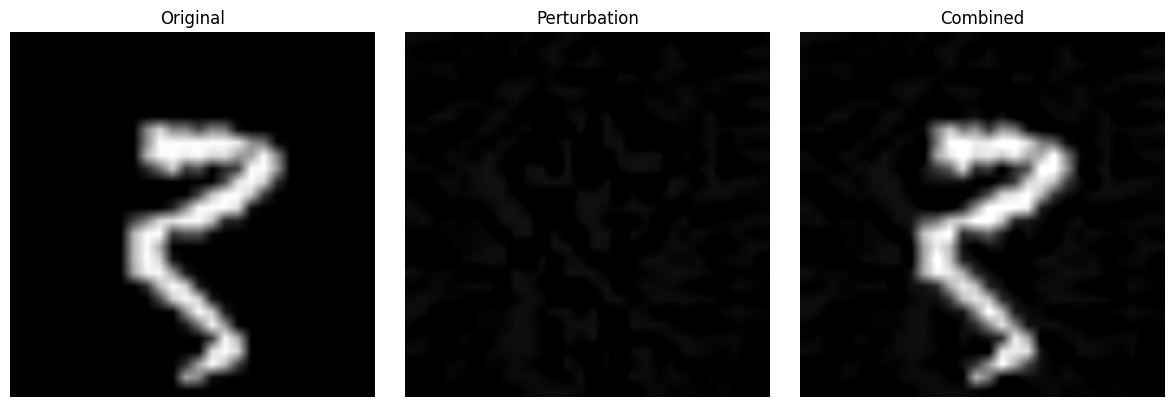

torch.Size([1, 1, 28, 28]) torch.Size([1, 3, 224, 224]) torch.Size([])
Step 0, Loss: 7.6715, Predicted: 8
Step 2, Loss: 7.6463, Predicted: 8
Step 4, Loss: 7.6164, Predicted: 8
Step 6, Loss: 7.5858, Predicted: 8
Step 8, Loss: 7.5513, Predicted: 8
Step 10, Loss: 7.5119, Predicted: 8
Step 12, Loss: 7.4644, Predicted: 8
Step 14, Loss: 7.4085, Predicted: 8
Step 16, Loss: 7.3391, Predicted: 8
Step 18, Loss: 7.2523, Predicted: 8
Step 20, Loss: 7.1443, Predicted: 8
Step 22, Loss: 7.0010, Predicted: 8
Step 24, Loss: 6.8300, Predicted: 8
Step 26, Loss: 6.6099, Predicted: 8
Step 28, Loss: 6.3060, Predicted: 8
Step 30, Loss: 5.8854, Predicted: 8
Step 32, Loss: 5.2886, Predicted: 8
Step 34, Loss: 4.4497, Predicted: 8
Step 36, Loss: 3.3378, Predicted: 8
Step 38, Loss: 1.9794, Predicted: 8
Step 40, Loss: 0.7574, Predicted: 8
SUCCESS!!!! 3
0.0004912362


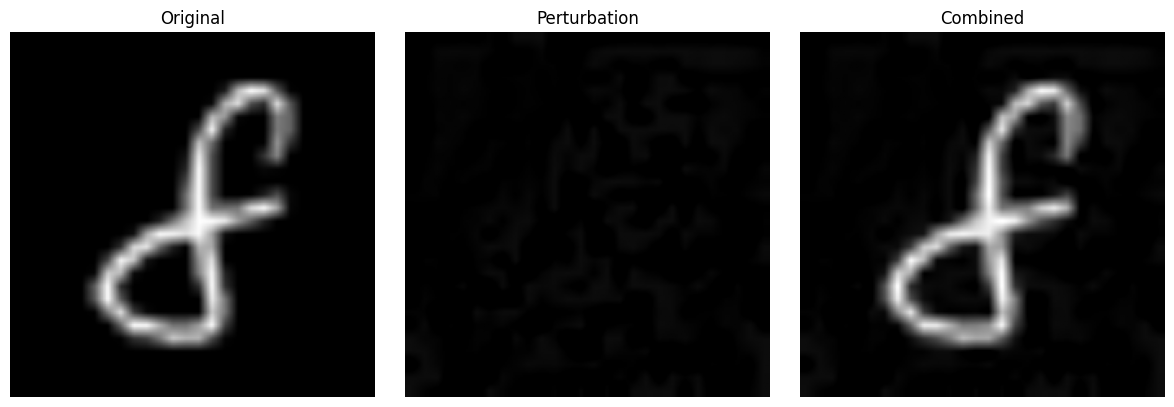

torch.Size([1, 1, 28, 28]) torch.Size([1, 3, 224, 224]) torch.Size([])
Step 0, Loss: 7.7025, Predicted: 8
Step 2, Loss: 7.6840, Predicted: 8
Step 4, Loss: 7.6598, Predicted: 8
Step 6, Loss: 7.6406, Predicted: 8
Step 8, Loss: 7.6195, Predicted: 8
Step 10, Loss: 7.5977, Predicted: 8
Step 12, Loss: 7.5749, Predicted: 8
Step 14, Loss: 7.5499, Predicted: 8
Step 16, Loss: 7.5249, Predicted: 8
Step 18, Loss: 7.4943, Predicted: 8
Step 20, Loss: 7.4649, Predicted: 8
Step 22, Loss: 7.4354, Predicted: 8
Step 24, Loss: 7.4062, Predicted: 8
Step 26, Loss: 7.3759, Predicted: 8
Step 28, Loss: 7.3445, Predicted: 8
Step 30, Loss: 7.3131, Predicted: 8
Step 32, Loss: 7.2809, Predicted: 8
Step 34, Loss: 7.2490, Predicted: 8
Step 36, Loss: 7.2160, Predicted: 8
Step 38, Loss: 7.1814, Predicted: 8
Step 40, Loss: 7.1452, Predicted: 8
Step 42, Loss: 7.1082, Predicted: 8
Step 44, Loss: 7.0643, Predicted: 8
Step 46, Loss: 7.0175, Predicted: 8
Step 48, Loss: 6.9631, Predicted: 8
Step 50, Loss: 6.9012, Predicted: 

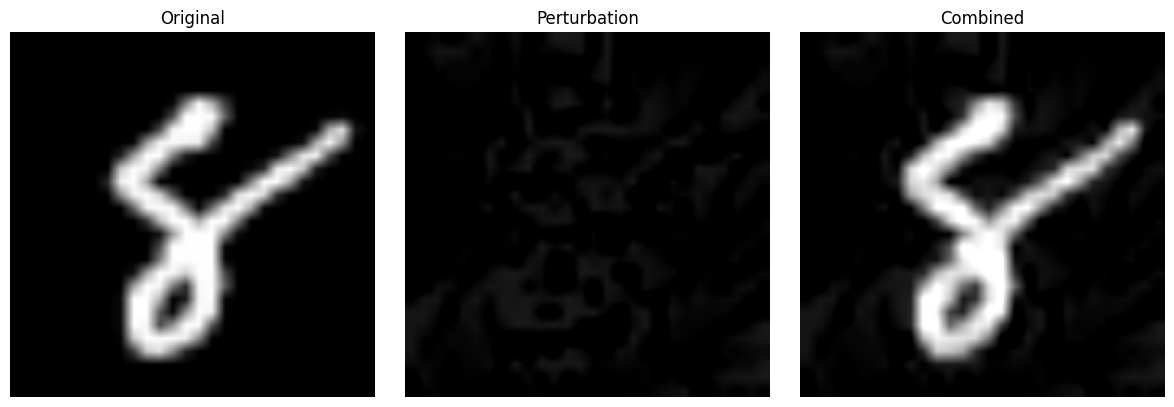

torch.Size([1, 1, 28, 28]) torch.Size([1, 3, 224, 224]) torch.Size([])
Step 0, Loss: 7.2961, Predicted: 8
Step 2, Loss: 7.2570, Predicted: 8
Step 4, Loss: 7.2124, Predicted: 8
Step 6, Loss: 7.1602, Predicted: 8
Step 8, Loss: 7.0968, Predicted: 8
Step 10, Loss: 7.0199, Predicted: 8
Step 12, Loss: 6.9274, Predicted: 8
Step 14, Loss: 6.8185, Predicted: 8
Step 16, Loss: 6.6902, Predicted: 8
Step 18, Loss: 6.5408, Predicted: 8
Step 20, Loss: 6.3680, Predicted: 8
Step 22, Loss: 6.1702, Predicted: 8
Step 24, Loss: 5.9448, Predicted: 8
Step 26, Loss: 5.6833, Predicted: 8
Step 28, Loss: 5.3751, Predicted: 8
Step 30, Loss: 5.0055, Predicted: 8
Step 32, Loss: 4.5535, Predicted: 8
Step 34, Loss: 3.9946, Predicted: 8
Step 36, Loss: 3.3035, Predicted: 8
Step 38, Loss: 2.4814, Predicted: 8
Step 40, Loss: 1.5948, Predicted: 8
Step 42, Loss: 0.8088, Predicted: 8
SUCCESS!!!! 3
0.0006779707


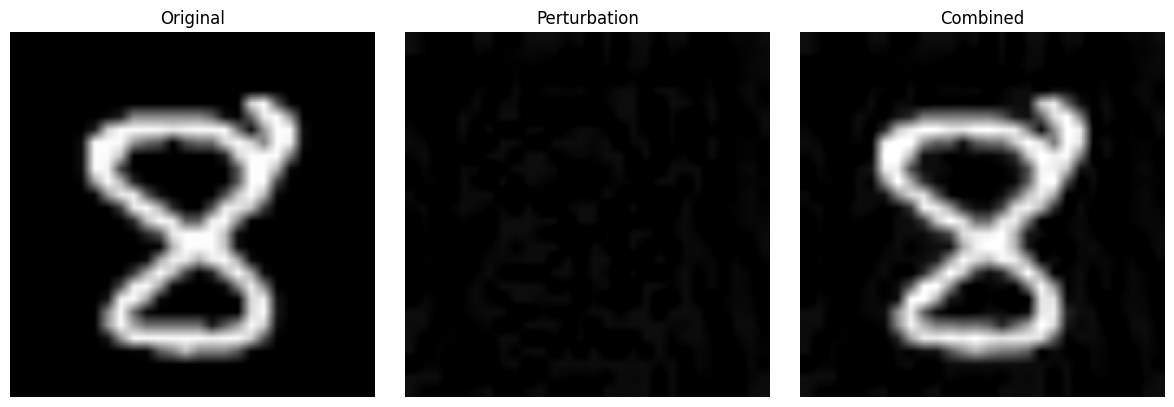

torch.Size([1, 1, 28, 28]) torch.Size([1, 3, 224, 224]) torch.Size([])
Step 0, Loss: 7.9708, Predicted: 3
Step 2, Loss: 7.9528, Predicted: 3
Step 4, Loss: 7.9345, Predicted: 3
Step 6, Loss: 7.9145, Predicted: 3
Step 8, Loss: 7.8930, Predicted: 3
Step 10, Loss: 7.8696, Predicted: 3
Step 12, Loss: 7.8445, Predicted: 3
Step 14, Loss: 7.8161, Predicted: 3
Step 16, Loss: 7.7880, Predicted: 3
Step 18, Loss: 7.7566, Predicted: 3
Step 20, Loss: 7.7201, Predicted: 3
Step 22, Loss: 7.6778, Predicted: 3
Step 24, Loss: 7.6281, Predicted: 3
Step 26, Loss: 7.5724, Predicted: 3
Step 28, Loss: 7.5094, Predicted: 3
Step 30, Loss: 7.4369, Predicted: 3
Step 32, Loss: 7.3590, Predicted: 3
Step 34, Loss: 7.2710, Predicted: 3
Step 36, Loss: 7.1762, Predicted: 3
Step 38, Loss: 7.0673, Predicted: 3
Step 40, Loss: 6.9515, Predicted: 3
Step 42, Loss: 6.8114, Predicted: 3
Step 44, Loss: 6.6531, Predicted: 3
Step 46, Loss: 6.4650, Predicted: 3
Step 48, Loss: 6.2366, Predicted: 3
Step 50, Loss: 5.9507, Predicted: 

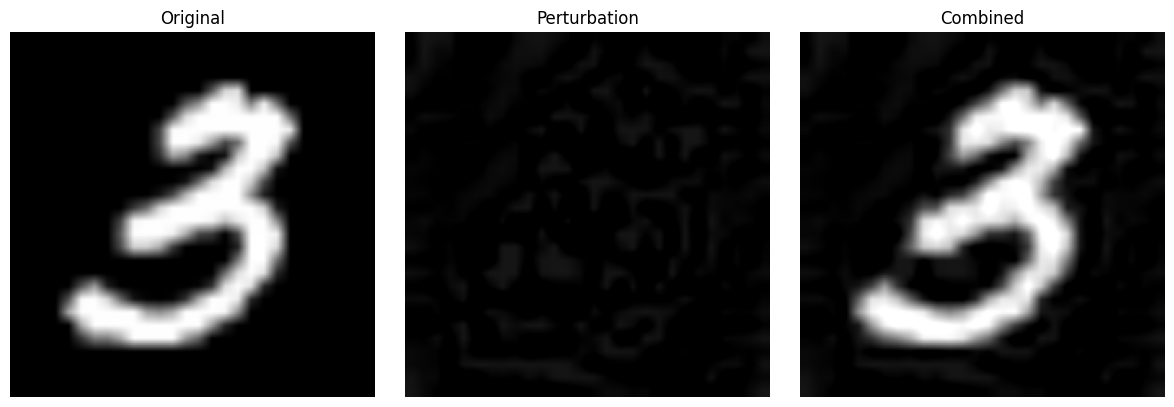

torch.Size([1, 1, 28, 28]) torch.Size([1, 3, 224, 224]) torch.Size([])
Step 0, Loss: 5.8621, Predicted: 8
Step 2, Loss: 5.6130, Predicted: 8
Step 4, Loss: 5.2993, Predicted: 8
Step 6, Loss: 4.9649, Predicted: 8
Step 8, Loss: 4.6082, Predicted: 8
Step 10, Loss: 4.2124, Predicted: 8
Step 12, Loss: 3.7883, Predicted: 8
Step 14, Loss: 3.3380, Predicted: 8
Step 16, Loss: 2.8714, Predicted: 8
Step 18, Loss: 2.4037, Predicted: 8
Step 20, Loss: 1.9358, Predicted: 8
Step 22, Loss: 1.4857, Predicted: 8
Step 24, Loss: 1.0756, Predicted: 8
Step 26, Loss: 0.7346, Predicted: 8
SUCCESS!!!! 3
0.00019054709


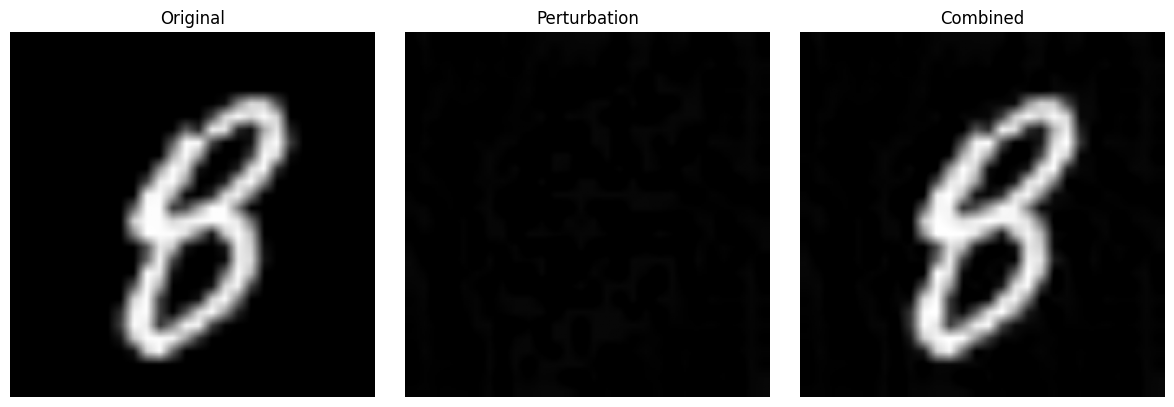

torch.Size([1, 1, 28, 28]) torch.Size([1, 3, 224, 224]) torch.Size([])
Step 0, Loss: 7.6140, Predicted: 3
Step 2, Loss: 7.5808, Predicted: 3
Step 4, Loss: 7.5413, Predicted: 3
Step 6, Loss: 7.4972, Predicted: 3
Step 8, Loss: 7.4473, Predicted: 3
Step 10, Loss: 7.3913, Predicted: 3
Step 12, Loss: 7.3296, Predicted: 3
Step 14, Loss: 7.2579, Predicted: 3
Step 16, Loss: 7.1752, Predicted: 3
Step 18, Loss: 7.0786, Predicted: 3
Step 20, Loss: 6.9661, Predicted: 3
Step 22, Loss: 6.8368, Predicted: 3
Step 24, Loss: 6.6859, Predicted: 3
Step 26, Loss: 6.5131, Predicted: 3
Step 28, Loss: 6.3060, Predicted: 3
Step 30, Loss: 6.0615, Predicted: 3
Step 32, Loss: 5.7678, Predicted: 3
Step 34, Loss: 5.4093, Predicted: 3
Step 36, Loss: 4.9601, Predicted: 3
Step 38, Loss: 4.3687, Predicted: 3
Step 40, Loss: 3.5668, Predicted: 3
Step 42, Loss: 2.4958, Predicted: 3
Step 44, Loss: 1.3357, Predicted: 3
SUCCESS!!!! 8
0.0006838882


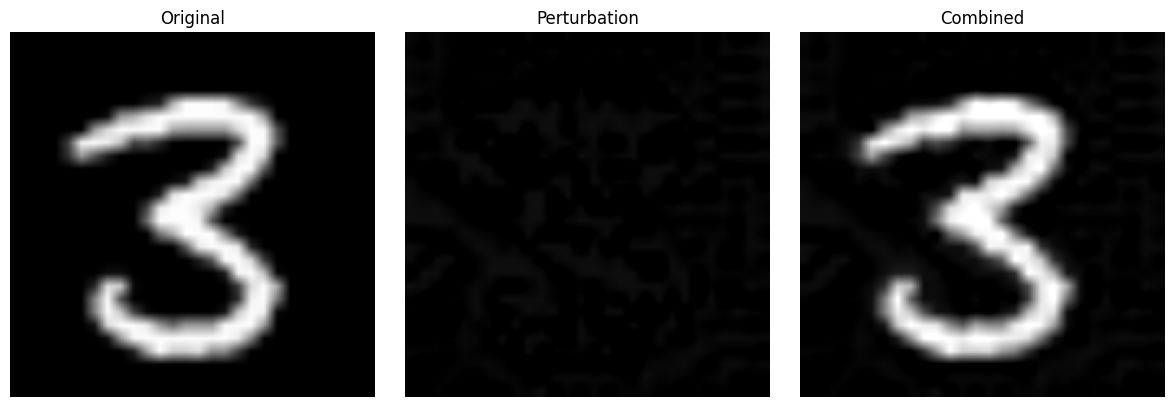

torch.Size([1, 1, 28, 28]) torch.Size([1, 3, 224, 224]) torch.Size([])
Step 0, Loss: 7.7758, Predicted: 8
Step 2, Loss: 7.7518, Predicted: 8
Step 4, Loss: 7.7282, Predicted: 8
Step 6, Loss: 7.7016, Predicted: 8
Step 8, Loss: 7.6744, Predicted: 8
Step 10, Loss: 7.6425, Predicted: 8
Step 12, Loss: 7.6078, Predicted: 8
Step 14, Loss: 7.5695, Predicted: 8
Step 16, Loss: 7.5255, Predicted: 8
Step 18, Loss: 7.4755, Predicted: 8
Step 20, Loss: 7.4200, Predicted: 8
Step 22, Loss: 7.3606, Predicted: 8
Step 24, Loss: 7.2993, Predicted: 8
Step 26, Loss: 7.2343, Predicted: 8
Step 28, Loss: 7.1664, Predicted: 8
Step 30, Loss: 7.0931, Predicted: 8
Step 32, Loss: 7.0116, Predicted: 8
Step 34, Loss: 6.9125, Predicted: 8
Step 36, Loss: 6.7878, Predicted: 8
Step 38, Loss: 6.6251, Predicted: 8
Step 40, Loss: 6.3947, Predicted: 8
Step 42, Loss: 6.0289, Predicted: 8
Step 44, Loss: 5.4086, Predicted: 8
Step 46, Loss: 4.3396, Predicted: 8
Step 48, Loss: 2.6603, Predicted: 8
Step 50, Loss: 0.8812, Predicted: 

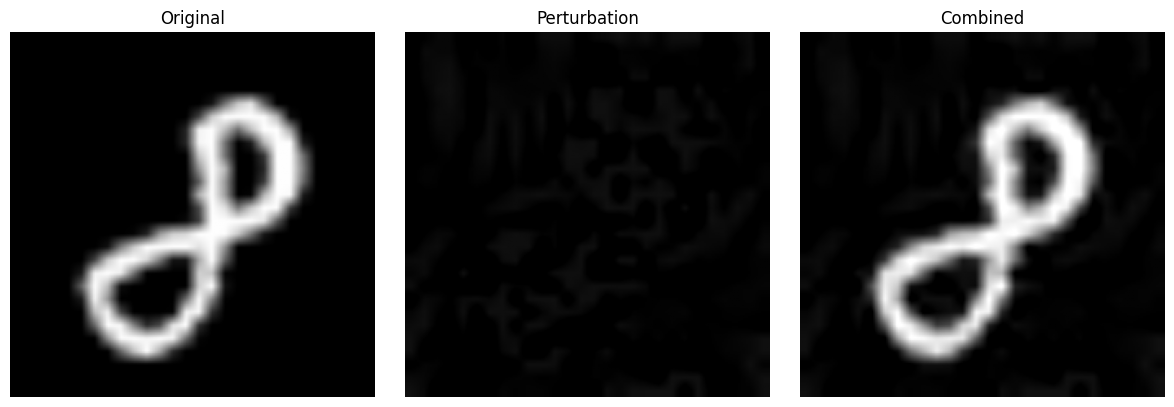

torch.Size([1, 1, 28, 28]) torch.Size([1, 3, 224, 224]) torch.Size([])
Step 0, Loss: 7.3463, Predicted: 8
Step 2, Loss: 7.2967, Predicted: 8
Step 4, Loss: 7.2418, Predicted: 8
Step 6, Loss: 7.1803, Predicted: 8
Step 8, Loss: 7.1147, Predicted: 8
Step 10, Loss: 7.0414, Predicted: 8
Step 12, Loss: 6.9601, Predicted: 8
Step 14, Loss: 6.8677, Predicted: 8
Step 16, Loss: 6.7632, Predicted: 8
Step 18, Loss: 6.6453, Predicted: 8
Step 20, Loss: 6.5124, Predicted: 8
Step 22, Loss: 6.3606, Predicted: 8
Step 24, Loss: 6.1869, Predicted: 8
Step 26, Loss: 5.9879, Predicted: 8
Step 28, Loss: 5.7537, Predicted: 8
Step 30, Loss: 5.4706, Predicted: 8
Step 32, Loss: 5.1226, Predicted: 8
Step 34, Loss: 4.6812, Predicted: 8
Step 36, Loss: 4.1015, Predicted: 8
Step 38, Loss: 3.3468, Predicted: 8
Step 40, Loss: 2.4110, Predicted: 8
Step 42, Loss: 1.3990, Predicted: 8
SUCCESS!!!! 3
0.000651254


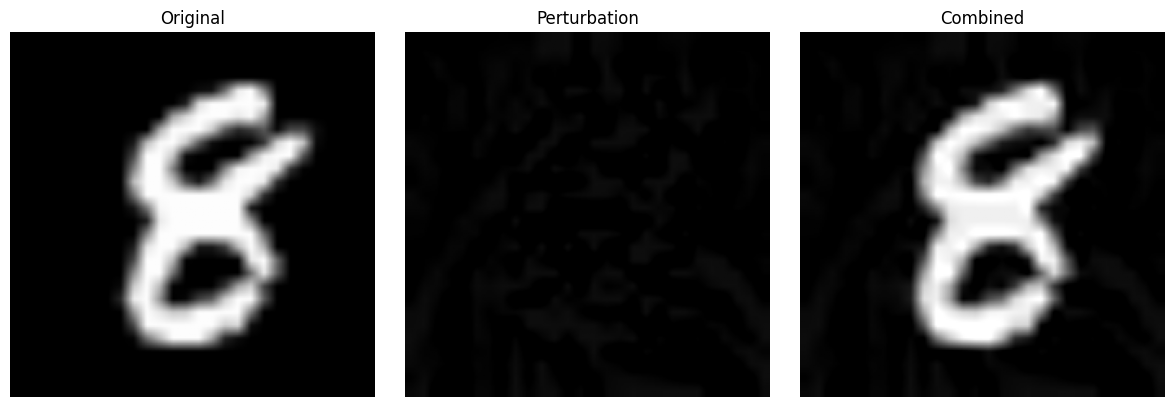

torch.Size([1, 1, 28, 28]) torch.Size([1, 3, 224, 224]) torch.Size([])
Step 0, Loss: 7.5864, Predicted: 8
Step 2, Loss: 7.5553, Predicted: 8
Step 4, Loss: 7.5208, Predicted: 8
Step 6, Loss: 7.4823, Predicted: 8
Step 8, Loss: 7.4380, Predicted: 8
Step 10, Loss: 7.3865, Predicted: 8
Step 12, Loss: 7.3261, Predicted: 8
Step 14, Loss: 7.2564, Predicted: 8
Step 16, Loss: 7.1767, Predicted: 8
Step 18, Loss: 7.0866, Predicted: 8
Step 20, Loss: 6.9849, Predicted: 8
Step 22, Loss: 6.8693, Predicted: 8
Step 24, Loss: 6.7353, Predicted: 8
Step 26, Loss: 6.5782, Predicted: 8
Step 28, Loss: 6.3920, Predicted: 8
Step 30, Loss: 6.1643, Predicted: 8
Step 32, Loss: 5.8754, Predicted: 8
Step 34, Loss: 5.4936, Predicted: 8
Step 36, Loss: 4.9775, Predicted: 8
Step 38, Loss: 4.2591, Predicted: 8
Step 40, Loss: 3.2291, Predicted: 8
Step 42, Loss: 1.9201, Predicted: 8
SUCCESS!!!! 3
0.0006716996


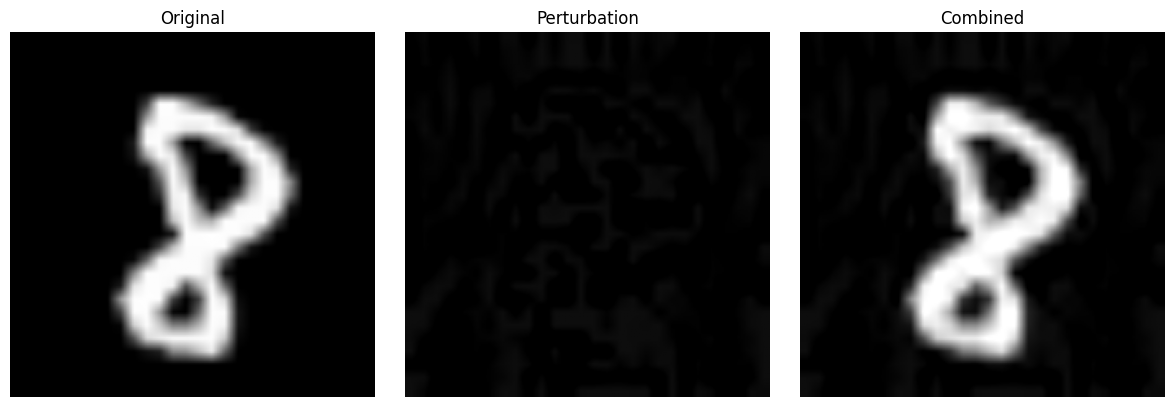

torch.Size([1, 1, 28, 28]) torch.Size([1, 3, 224, 224]) torch.Size([])
Step 0, Loss: 7.4297, Predicted: 8
Step 2, Loss: 7.4000, Predicted: 8
Step 4, Loss: 7.3681, Predicted: 8
Step 6, Loss: 7.3323, Predicted: 8
Step 8, Loss: 7.2903, Predicted: 8
Step 10, Loss: 7.2412, Predicted: 8
Step 12, Loss: 7.1866, Predicted: 8
Step 14, Loss: 7.1275, Predicted: 8
Step 16, Loss: 7.0654, Predicted: 8
Step 18, Loss: 7.0001, Predicted: 8
Step 20, Loss: 6.9313, Predicted: 8
Step 22, Loss: 6.8595, Predicted: 8
Step 24, Loss: 6.7839, Predicted: 8
Step 26, Loss: 6.7022, Predicted: 8
Step 28, Loss: 6.6132, Predicted: 8
Step 30, Loss: 6.5139, Predicted: 8
Step 32, Loss: 6.4018, Predicted: 8
Step 34, Loss: 6.2691, Predicted: 8
Step 36, Loss: 6.1139, Predicted: 8
Step 38, Loss: 5.9299, Predicted: 8
Step 40, Loss: 5.7094, Predicted: 8
Step 42, Loss: 5.4462, Predicted: 8
Step 44, Loss: 5.1328, Predicted: 8
Step 46, Loss: 4.7533, Predicted: 8
Step 48, Loss: 4.2826, Predicted: 8
Step 50, Loss: 3.7021, Predicted: 

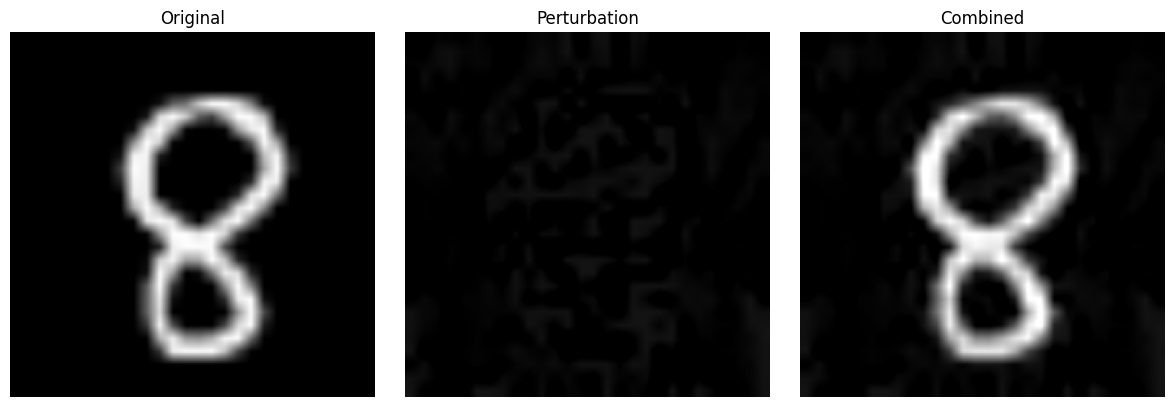

torch.Size([1, 1, 28, 28]) torch.Size([1, 3, 224, 224]) torch.Size([])
Step 0, Loss: 7.9678, Predicted: 3
Step 2, Loss: 7.9501, Predicted: 3
Step 4, Loss: 7.9316, Predicted: 3
Step 6, Loss: 7.9101, Predicted: 3
Step 8, Loss: 7.8900, Predicted: 3
Step 10, Loss: 7.8656, Predicted: 3
Step 12, Loss: 7.8416, Predicted: 3
Step 14, Loss: 7.8207, Predicted: 3
Step 16, Loss: 7.7963, Predicted: 3
Step 18, Loss: 7.7708, Predicted: 3
Step 20, Loss: 7.7465, Predicted: 3
Step 22, Loss: 7.7208, Predicted: 3
Step 24, Loss: 7.6937, Predicted: 3
Step 26, Loss: 7.6672, Predicted: 3
Step 28, Loss: 7.6398, Predicted: 3
Step 30, Loss: 7.6099, Predicted: 3
Step 32, Loss: 7.5775, Predicted: 3
Step 34, Loss: 7.5419, Predicted: 3
Step 36, Loss: 7.5026, Predicted: 3
Step 38, Loss: 7.4590, Predicted: 3
Step 40, Loss: 7.4104, Predicted: 3
Step 42, Loss: 7.3549, Predicted: 3
Step 44, Loss: 7.2963, Predicted: 3
Step 46, Loss: 7.2299, Predicted: 3
Step 48, Loss: 7.1521, Predicted: 3
Step 50, Loss: 7.0679, Predicted: 

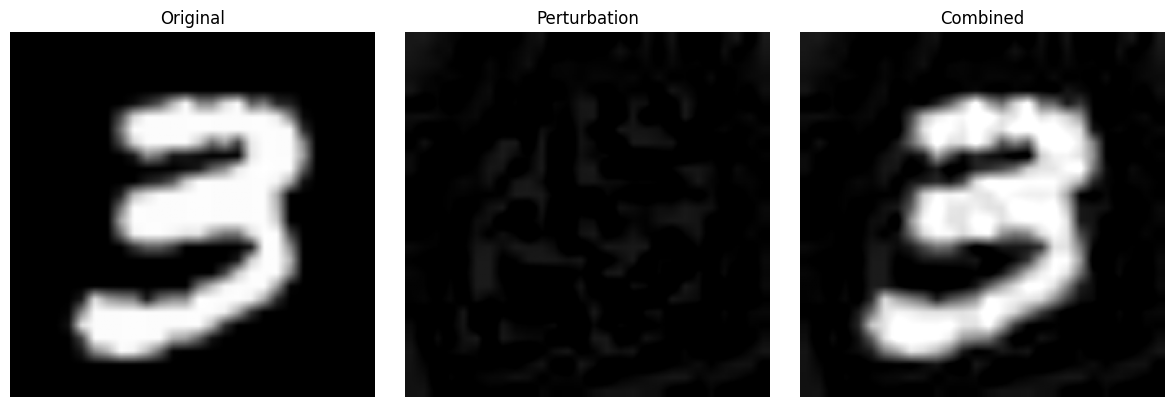

torch.Size([1, 1, 28, 28]) torch.Size([1, 3, 224, 224]) torch.Size([])
Step 0, Loss: 7.8925, Predicted: 3
Step 2, Loss: 7.8733, Predicted: 3
Step 4, Loss: 7.8487, Predicted: 3
Step 6, Loss: 7.8228, Predicted: 3
Step 8, Loss: 7.7935, Predicted: 3
Step 10, Loss: 7.7595, Predicted: 3
Step 12, Loss: 7.7202, Predicted: 3
Step 14, Loss: 7.6764, Predicted: 3
Step 16, Loss: 7.6310, Predicted: 3
Step 18, Loss: 7.5819, Predicted: 3
Step 20, Loss: 7.5295, Predicted: 3
Step 22, Loss: 7.4754, Predicted: 3
Step 24, Loss: 7.4124, Predicted: 3
Step 26, Loss: 7.3387, Predicted: 3
Step 28, Loss: 7.2503, Predicted: 3
Step 30, Loss: 7.1593, Predicted: 3
Step 32, Loss: 7.0385, Predicted: 3
Step 34, Loss: 6.9077, Predicted: 3
Step 36, Loss: 6.7572, Predicted: 3
Step 38, Loss: 6.5677, Predicted: 3
Step 40, Loss: 6.3447, Predicted: 3
Step 42, Loss: 6.0784, Predicted: 3
Step 44, Loss: 5.7431, Predicted: 3
Step 46, Loss: 5.3283, Predicted: 3
Step 48, Loss: 4.7756, Predicted: 3
Step 50, Loss: 4.0602, Predicted: 

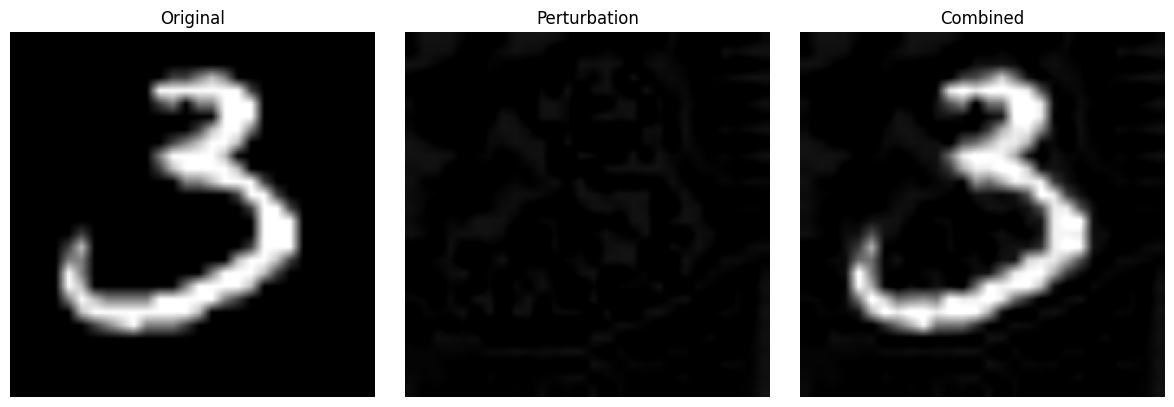

torch.Size([1, 1, 28, 28]) torch.Size([1, 3, 224, 224]) torch.Size([])
Step 0, Loss: 7.6162, Predicted: 8
Step 2, Loss: 7.5981, Predicted: 8
Step 4, Loss: 7.5765, Predicted: 8
Step 6, Loss: 7.5550, Predicted: 8
Step 8, Loss: 7.5318, Predicted: 8
Step 10, Loss: 7.5071, Predicted: 8
Step 12, Loss: 7.4824, Predicted: 8
Step 14, Loss: 7.4547, Predicted: 8
Step 16, Loss: 7.4282, Predicted: 8
Step 18, Loss: 7.4011, Predicted: 8
Step 20, Loss: 7.3730, Predicted: 8
Step 22, Loss: 7.3447, Predicted: 8
Step 24, Loss: 7.3177, Predicted: 8
Step 26, Loss: 7.2893, Predicted: 8
Step 28, Loss: 7.2594, Predicted: 8
Step 30, Loss: 7.2262, Predicted: 8
Step 32, Loss: 7.1917, Predicted: 8
Step 34, Loss: 7.1582, Predicted: 8
Step 36, Loss: 7.1175, Predicted: 8
Step 38, Loss: 7.0761, Predicted: 8
Step 40, Loss: 7.0286, Predicted: 8
Step 42, Loss: 6.9755, Predicted: 8
Step 44, Loss: 6.9126, Predicted: 8
Step 46, Loss: 6.8396, Predicted: 8
Step 48, Loss: 6.7419, Predicted: 8
Step 50, Loss: 6.6237, Predicted: 

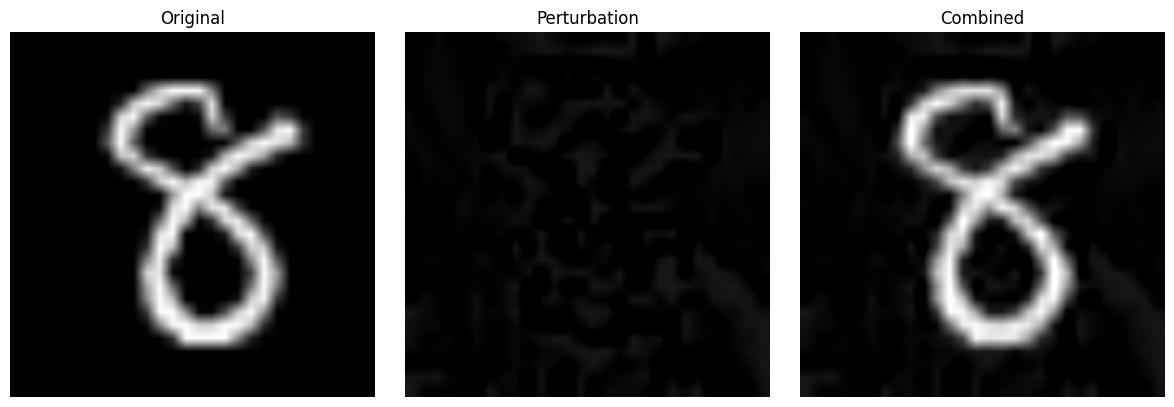

torch.Size([1, 1, 28, 28]) torch.Size([1, 3, 224, 224]) torch.Size([])
Step 0, Loss: 7.7789, Predicted: 3
Step 2, Loss: 7.7534, Predicted: 3
Step 4, Loss: 7.7249, Predicted: 3
Step 6, Loss: 7.6933, Predicted: 3
Step 8, Loss: 7.6580, Predicted: 3
Step 10, Loss: 7.6156, Predicted: 3
Step 12, Loss: 7.5702, Predicted: 3
Step 14, Loss: 7.5168, Predicted: 3
Step 16, Loss: 7.4552, Predicted: 3
Step 18, Loss: 7.3882, Predicted: 3
Step 20, Loss: 7.3121, Predicted: 3
Step 22, Loss: 7.2257, Predicted: 3
Step 24, Loss: 7.1285, Predicted: 3
Step 26, Loss: 7.0070, Predicted: 3
Step 28, Loss: 6.8634, Predicted: 3
Step 30, Loss: 6.6871, Predicted: 3
Step 32, Loss: 6.4698, Predicted: 3
Step 34, Loss: 6.2002, Predicted: 3
Step 36, Loss: 5.8777, Predicted: 3
Step 38, Loss: 5.4885, Predicted: 3
Step 40, Loss: 4.9970, Predicted: 3
Step 42, Loss: 4.3800, Predicted: 3
Step 44, Loss: 3.6476, Predicted: 3
Step 46, Loss: 2.8374, Predicted: 3
Step 48, Loss: 1.9842, Predicted: 3
Step 50, Loss: 1.2359, Predicted: 

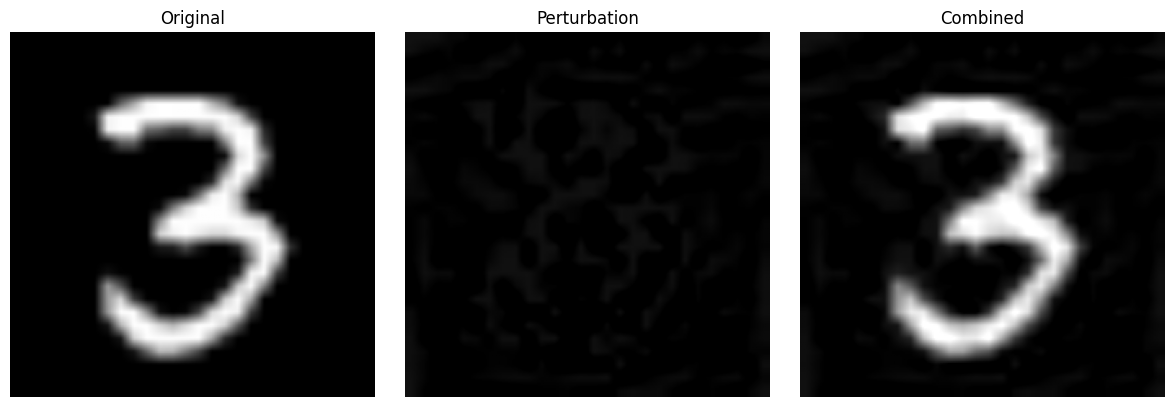

torch.Size([1, 1, 28, 28]) torch.Size([1, 3, 224, 224]) torch.Size([])
Step 0, Loss: 8.0190, Predicted: 3
Step 2, Loss: 8.0009, Predicted: 3
Step 4, Loss: 7.9835, Predicted: 3
Step 6, Loss: 7.9654, Predicted: 3
Step 8, Loss: 7.9465, Predicted: 3
Step 10, Loss: 7.9266, Predicted: 3
Step 12, Loss: 7.9046, Predicted: 3
Step 14, Loss: 7.8821, Predicted: 3
Step 16, Loss: 7.8573, Predicted: 3
Step 18, Loss: 7.8299, Predicted: 3
Step 20, Loss: 7.7984, Predicted: 3
Step 22, Loss: 7.7708, Predicted: 3
Step 24, Loss: 7.7343, Predicted: 3
Step 26, Loss: 7.6963, Predicted: 3
Step 28, Loss: 7.6503, Predicted: 3
Step 30, Loss: 7.5939, Predicted: 3
Step 32, Loss: 7.5273, Predicted: 3
Step 34, Loss: 7.4392, Predicted: 3
Step 36, Loss: 7.3320, Predicted: 3
Step 38, Loss: 7.2018, Predicted: 3
Step 40, Loss: 7.0504, Predicted: 3
Step 42, Loss: 6.8866, Predicted: 3
Step 44, Loss: 6.6956, Predicted: 3
Step 46, Loss: 6.4526, Predicted: 3
Step 48, Loss: 6.1379, Predicted: 3
Step 50, Loss: 5.7247, Predicted: 

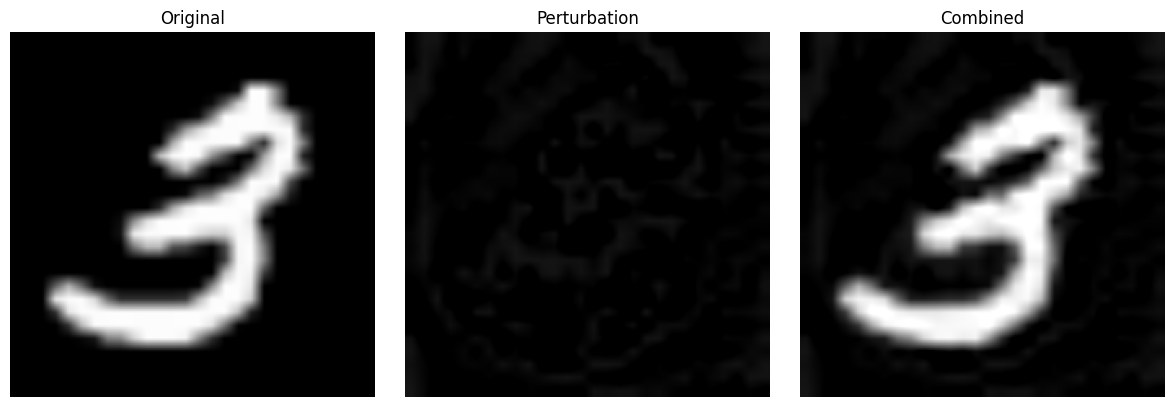

torch.Size([1, 1, 28, 28]) torch.Size([1, 3, 224, 224]) torch.Size([])
Step 0, Loss: 7.7876, Predicted: 3
Step 2, Loss: 7.7654, Predicted: 3
Step 4, Loss: 7.7403, Predicted: 3
Step 6, Loss: 7.7128, Predicted: 3
Step 8, Loss: 7.6825, Predicted: 3
Step 10, Loss: 7.6553, Predicted: 3
Step 12, Loss: 7.6264, Predicted: 3
Step 14, Loss: 7.5958, Predicted: 3
Step 16, Loss: 7.5625, Predicted: 3
Step 18, Loss: 7.5281, Predicted: 3
Step 20, Loss: 7.4897, Predicted: 3
Step 22, Loss: 7.4472, Predicted: 3
Step 24, Loss: 7.4003, Predicted: 3
Step 26, Loss: 7.3463, Predicted: 3
Step 28, Loss: 7.2899, Predicted: 3
Step 30, Loss: 7.2257, Predicted: 3
Step 32, Loss: 7.1525, Predicted: 3
Step 34, Loss: 7.0713, Predicted: 3
Step 36, Loss: 6.9748, Predicted: 3
Step 38, Loss: 6.8574, Predicted: 3
Step 40, Loss: 6.7201, Predicted: 3
Step 42, Loss: 6.5588, Predicted: 3
Step 44, Loss: 6.3746, Predicted: 3
Step 46, Loss: 6.1587, Predicted: 3
Step 48, Loss: 5.9152, Predicted: 3
Step 50, Loss: 5.6376, Predicted: 

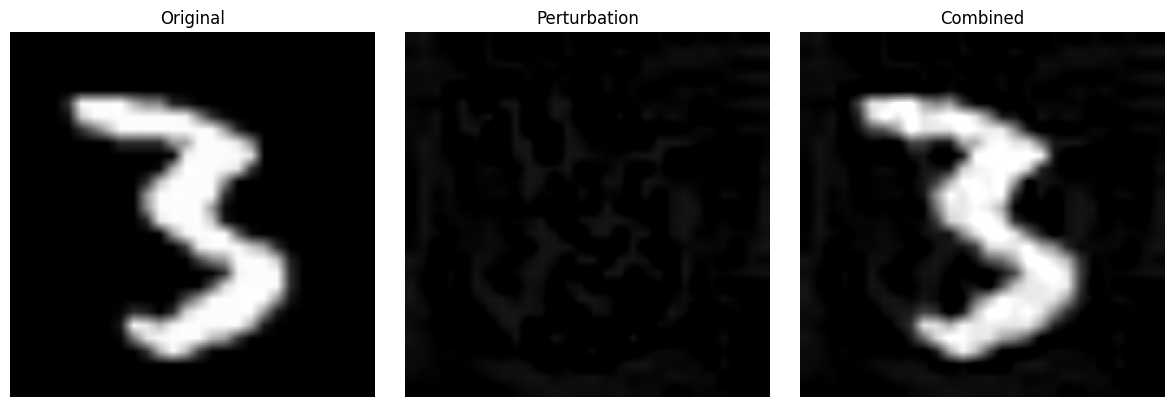

torch.Size([1, 1, 28, 28]) torch.Size([1, 3, 224, 224]) torch.Size([])
Step 0, Loss: 7.5074, Predicted: 3
Step 2, Loss: 7.4699, Predicted: 3
Step 4, Loss: 7.4314, Predicted: 3
Step 6, Loss: 7.3878, Predicted: 3
Step 8, Loss: 7.3382, Predicted: 3
Step 10, Loss: 7.2806, Predicted: 3
Step 12, Loss: 7.2127, Predicted: 3
Step 14, Loss: 7.1294, Predicted: 3
Step 16, Loss: 7.0258, Predicted: 3
Step 18, Loss: 6.8947, Predicted: 3
Step 20, Loss: 6.7215, Predicted: 3
Step 22, Loss: 6.4867, Predicted: 3
Step 24, Loss: 6.1604, Predicted: 3
Step 26, Loss: 5.7036, Predicted: 3
Step 28, Loss: 5.0390, Predicted: 3
Step 30, Loss: 4.1048, Predicted: 3
Step 32, Loss: 3.0124, Predicted: 3
Step 34, Loss: 1.8401, Predicted: 3
Step 36, Loss: 0.9363, Predicted: 3
SUCCESS!!!! 8
0.00039413272


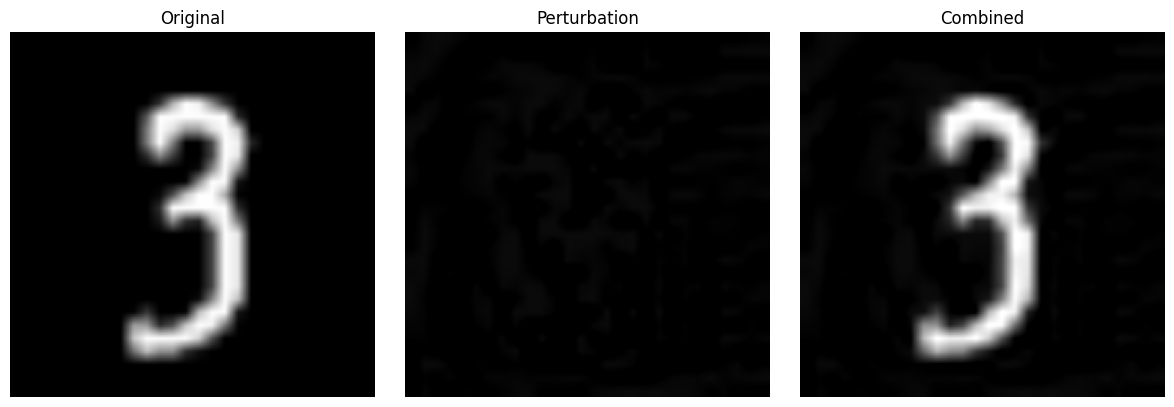

torch.Size([1, 1, 28, 28]) torch.Size([1, 3, 224, 224]) torch.Size([])
Step 0, Loss: 6.9429, Predicted: 8
Step 2, Loss: 6.8732, Predicted: 8
Step 4, Loss: 6.7917, Predicted: 8
Step 6, Loss: 6.6994, Predicted: 8
Step 8, Loss: 6.5928, Predicted: 8
Step 10, Loss: 6.4619, Predicted: 8
Step 12, Loss: 6.3040, Predicted: 8
Step 14, Loss: 6.1163, Predicted: 8
Step 16, Loss: 5.8968, Predicted: 8
Step 18, Loss: 5.6405, Predicted: 8
Step 20, Loss: 5.3307, Predicted: 8
Step 22, Loss: 4.9639, Predicted: 8
Step 24, Loss: 4.5450, Predicted: 8
Step 26, Loss: 4.1014, Predicted: 8
Step 28, Loss: 3.6381, Predicted: 8
Step 30, Loss: 3.1157, Predicted: 8
Step 32, Loss: 2.6785, Predicted: 8
Step 34, Loss: 2.5251, Predicted: 8
Step 36, Loss: 2.4249, Predicted: 6
Step 38, Loss: 2.2515, Predicted: 6
Step 40, Loss: 2.0321, Predicted: 6
Step 42, Loss: 1.8113, Predicted: 8
Step 44, Loss: 1.6280, Predicted: 8
Step 46, Loss: 1.4839, Predicted: 8
Step 48, Loss: 1.3519, Predicted: 8
Step 50, Loss: 1.2115, Predicted: 

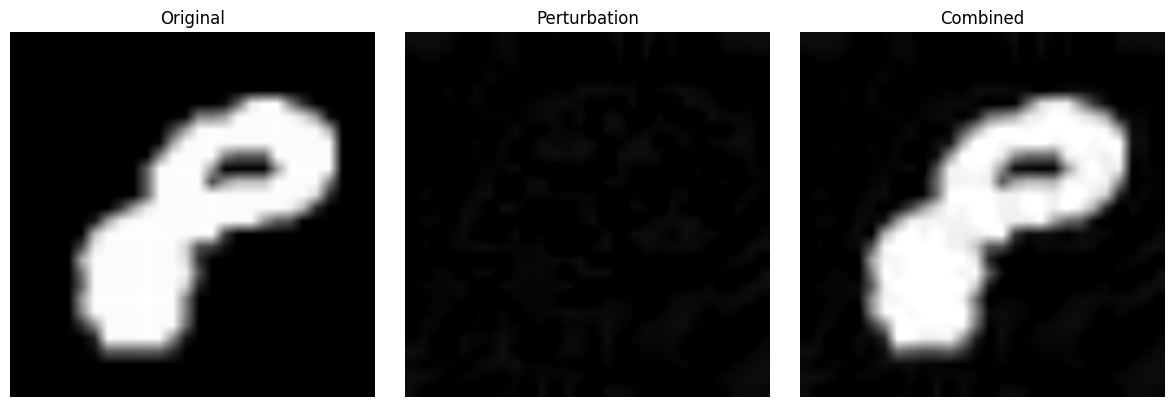

torch.Size([1, 1, 28, 28]) torch.Size([1, 3, 224, 224]) torch.Size([])
Step 0, Loss: 7.3472, Predicted: 3
Step 2, Loss: 7.3072, Predicted: 3
Step 4, Loss: 7.2612, Predicted: 3
Step 6, Loss: 7.2117, Predicted: 3
Step 8, Loss: 7.1587, Predicted: 3
Step 10, Loss: 7.1008, Predicted: 3
Step 12, Loss: 7.0363, Predicted: 3
Step 14, Loss: 6.9621, Predicted: 3
Step 16, Loss: 6.8818, Predicted: 3
Step 18, Loss: 6.7875, Predicted: 3
Step 20, Loss: 6.6789, Predicted: 3
Step 22, Loss: 6.5481, Predicted: 3
Step 24, Loss: 6.3902, Predicted: 3
Step 26, Loss: 6.2063, Predicted: 3
Step 28, Loss: 5.9858, Predicted: 3
Step 30, Loss: 5.7133, Predicted: 3
Step 32, Loss: 5.3736, Predicted: 3
Step 34, Loss: 4.9384, Predicted: 3
Step 36, Loss: 4.3670, Predicted: 3
Step 38, Loss: 3.5935, Predicted: 3
Step 40, Loss: 2.6449, Predicted: 3
Step 42, Loss: 1.6530, Predicted: 3
Step 44, Loss: 0.8410, Predicted: 3
SUCCESS!!!! 8
0.00061537


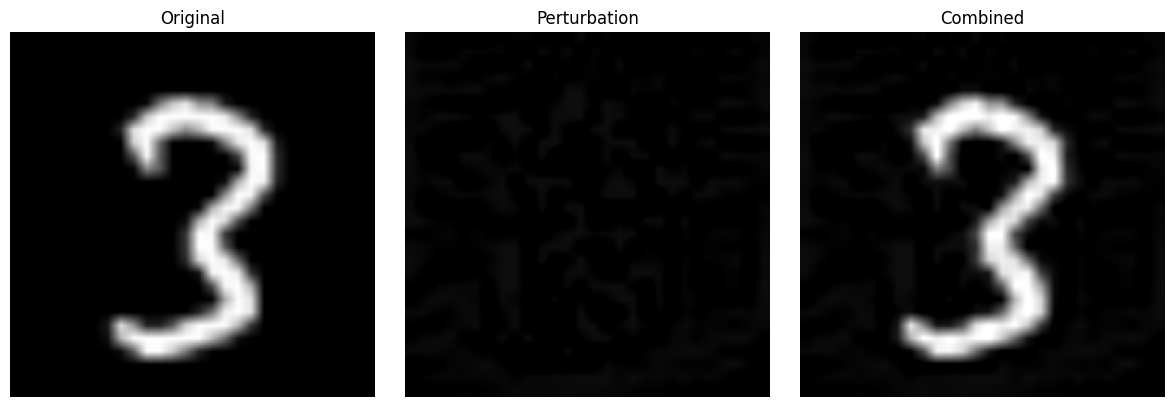

torch.Size([1, 1, 28, 28]) torch.Size([1, 3, 224, 224]) torch.Size([])
Step 0, Loss: 7.5804, Predicted: 8
Step 2, Loss: 7.5541, Predicted: 8
Step 4, Loss: 7.5262, Predicted: 8
Step 6, Loss: 7.4990, Predicted: 8
Step 8, Loss: 7.4699, Predicted: 8
Step 10, Loss: 7.4380, Predicted: 8
Step 12, Loss: 7.4043, Predicted: 8
Step 14, Loss: 7.3654, Predicted: 8
Step 16, Loss: 7.3250, Predicted: 8
Step 18, Loss: 7.2828, Predicted: 8
Step 20, Loss: 7.2406, Predicted: 8
Step 22, Loss: 7.1960, Predicted: 8
Step 24, Loss: 7.1493, Predicted: 8
Step 26, Loss: 7.0997, Predicted: 8
Step 28, Loss: 7.0461, Predicted: 8
Step 30, Loss: 6.9866, Predicted: 8
Step 32, Loss: 6.9228, Predicted: 8
Step 34, Loss: 6.8464, Predicted: 8
Step 36, Loss: 6.7623, Predicted: 8
Step 38, Loss: 6.6619, Predicted: 8
Step 40, Loss: 6.5390, Predicted: 8
Step 42, Loss: 6.3832, Predicted: 8
Step 44, Loss: 6.1688, Predicted: 8
Step 46, Loss: 5.8698, Predicted: 8
Step 48, Loss: 5.4116, Predicted: 8
Step 50, Loss: 4.5744, Predicted: 

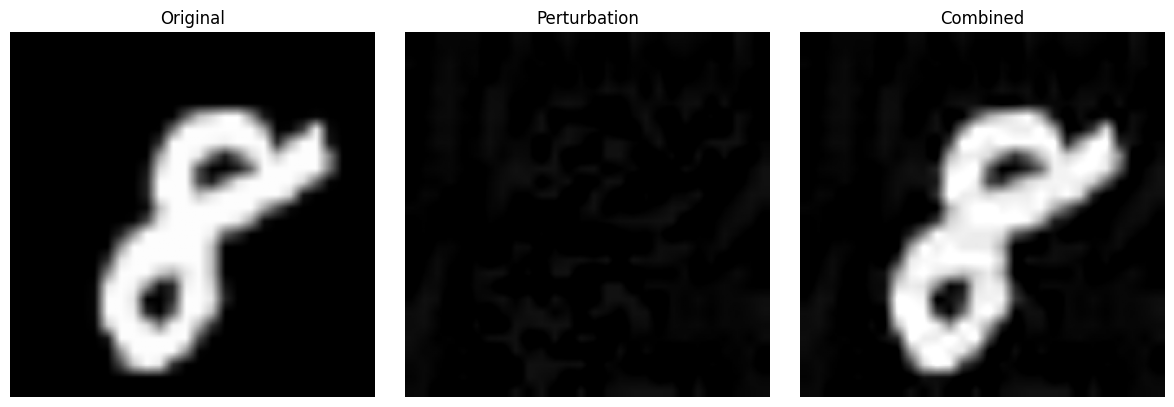

torch.Size([1, 1, 28, 28]) torch.Size([1, 3, 224, 224]) torch.Size([])
Step 0, Loss: 8.0105, Predicted: 3
Step 2, Loss: 7.9915, Predicted: 3
Step 4, Loss: 7.9678, Predicted: 3
Step 6, Loss: 7.9418, Predicted: 3
Step 8, Loss: 7.9108, Predicted: 3
Step 10, Loss: 7.8744, Predicted: 3
Step 12, Loss: 7.8354, Predicted: 3
Step 14, Loss: 7.7963, Predicted: 3
Step 16, Loss: 7.7538, Predicted: 3
Step 18, Loss: 7.7097, Predicted: 3
Step 20, Loss: 7.6629, Predicted: 3
Step 22, Loss: 7.6111, Predicted: 3
Step 24, Loss: 7.5561, Predicted: 3
Step 26, Loss: 7.4918, Predicted: 3
Step 28, Loss: 7.4163, Predicted: 3
Step 30, Loss: 7.3290, Predicted: 3
Step 32, Loss: 7.2230, Predicted: 3
Step 34, Loss: 7.0987, Predicted: 3
Step 36, Loss: 6.9503, Predicted: 3
Step 38, Loss: 6.7632, Predicted: 3
Step 40, Loss: 6.5282, Predicted: 3
Step 42, Loss: 6.2318, Predicted: 3
Step 44, Loss: 5.8717, Predicted: 3
Step 46, Loss: 5.4091, Predicted: 3
Step 48, Loss: 4.8141, Predicted: 3
Step 50, Loss: 4.0832, Predicted: 

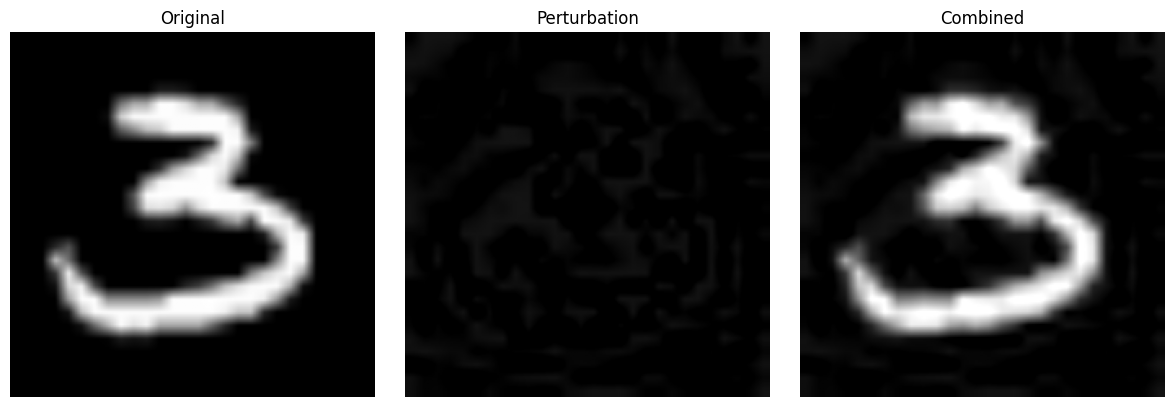

torch.Size([1, 1, 28, 28]) torch.Size([1, 3, 224, 224]) torch.Size([])
Step 0, Loss: 7.7242, Predicted: 3
Step 2, Loss: 7.6999, Predicted: 3
Step 4, Loss: 7.6705, Predicted: 3
Step 6, Loss: 7.6377, Predicted: 3
Step 8, Loss: 7.6011, Predicted: 3
Step 10, Loss: 7.5599, Predicted: 3
Step 12, Loss: 7.5160, Predicted: 3
Step 14, Loss: 7.4680, Predicted: 3
Step 16, Loss: 7.4150, Predicted: 3
Step 18, Loss: 7.3552, Predicted: 3
Step 20, Loss: 7.2860, Predicted: 3
Step 22, Loss: 7.2036, Predicted: 3
Step 24, Loss: 7.1024, Predicted: 3
Step 26, Loss: 6.9752, Predicted: 3
Step 28, Loss: 6.8136, Predicted: 3
Step 30, Loss: 6.6130, Predicted: 3
Step 32, Loss: 6.3421, Predicted: 3
Step 34, Loss: 5.9641, Predicted: 3
Step 36, Loss: 5.4405, Predicted: 3
Step 38, Loss: 4.8010, Predicted: 3
Step 40, Loss: 3.9558, Predicted: 3
Step 42, Loss: 2.8861, Predicted: 3
Step 44, Loss: 1.8022, Predicted: 3
Step 46, Loss: 0.9071, Predicted: 3
SUCCESS!!!! 8
0.0007582039


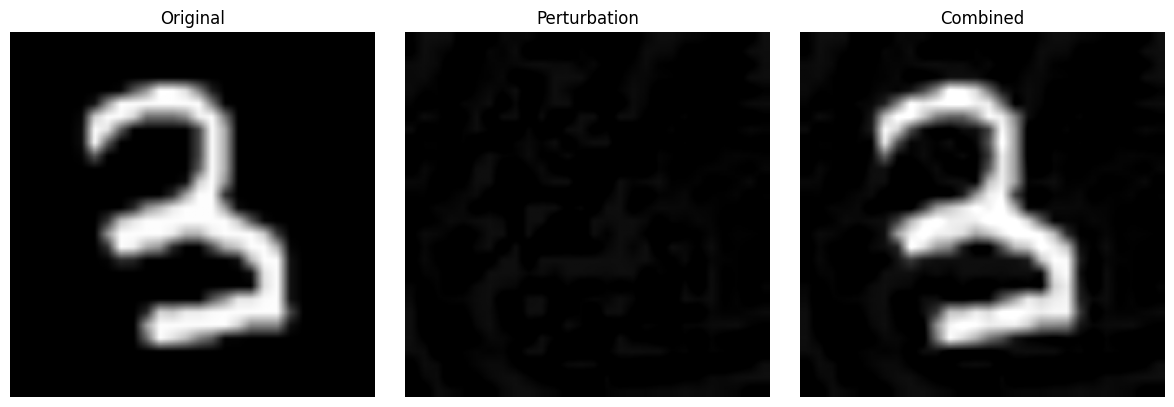

torch.Size([1, 1, 28, 28]) torch.Size([1, 3, 224, 224]) torch.Size([])
Step 0, Loss: 7.7766, Predicted: 3
Step 2, Loss: 7.7550, Predicted: 3
Step 4, Loss: 7.7309, Predicted: 3
Step 6, Loss: 7.7063, Predicted: 3
Step 8, Loss: 7.6800, Predicted: 3
Step 10, Loss: 7.6512, Predicted: 3
Step 12, Loss: 7.6200, Predicted: 3
Step 14, Loss: 7.5858, Predicted: 3
Step 16, Loss: 7.5485, Predicted: 3
Step 18, Loss: 7.5068, Predicted: 3
Step 20, Loss: 7.4579, Predicted: 3
Step 22, Loss: 7.4016, Predicted: 3
Step 24, Loss: 7.3344, Predicted: 3
Step 26, Loss: 7.2512, Predicted: 3
Step 28, Loss: 7.1486, Predicted: 3
Step 30, Loss: 7.0211, Predicted: 3
Step 32, Loss: 6.8531, Predicted: 3
Step 34, Loss: 6.6360, Predicted: 3
Step 36, Loss: 6.3768, Predicted: 3
Step 38, Loss: 6.0492, Predicted: 3
Step 40, Loss: 5.6359, Predicted: 3
Step 42, Loss: 5.1216, Predicted: 3
Step 44, Loss: 4.4776, Predicted: 3
Step 46, Loss: 3.6659, Predicted: 3
Step 48, Loss: 2.7208, Predicted: 3
Step 50, Loss: 1.7622, Predicted: 

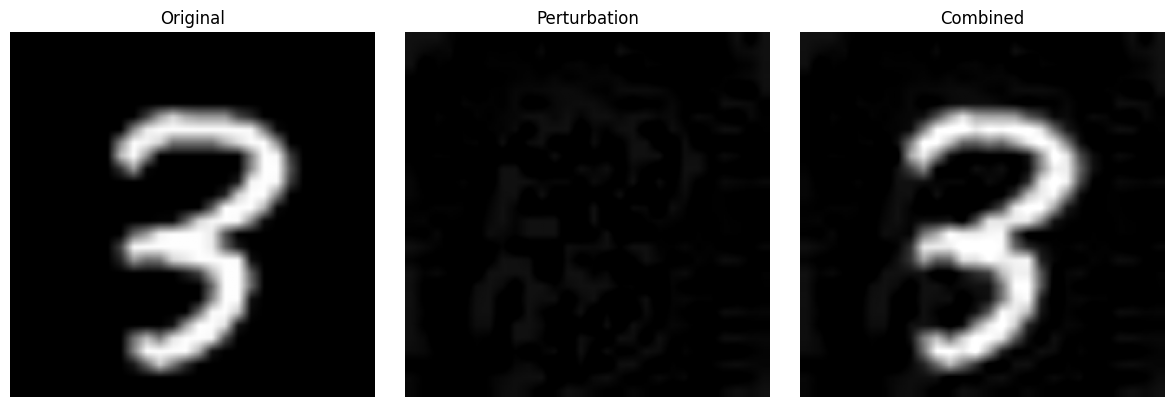

torch.Size([1, 1, 28, 28]) torch.Size([1, 3, 224, 224]) torch.Size([])
Step 0, Loss: 7.3454, Predicted: 8
Step 2, Loss: 7.2951, Predicted: 8
Step 4, Loss: 7.2459, Predicted: 8
Step 6, Loss: 7.1869, Predicted: 8
Step 8, Loss: 7.1195, Predicted: 8
Step 10, Loss: 7.0414, Predicted: 8
Step 12, Loss: 6.9482, Predicted: 8
Step 14, Loss: 6.8363, Predicted: 8
Step 16, Loss: 6.6998, Predicted: 8
Step 18, Loss: 6.5319, Predicted: 8
Step 20, Loss: 6.3172, Predicted: 8
Step 22, Loss: 6.0312, Predicted: 8
Step 24, Loss: 5.6366, Predicted: 8
Step 26, Loss: 5.0615, Predicted: 8
Step 28, Loss: 4.1678, Predicted: 8
Step 30, Loss: 2.7676, Predicted: 8
Step 32, Loss: 1.1419, Predicted: 8
SUCCESS!!!! 3
0.00029289888


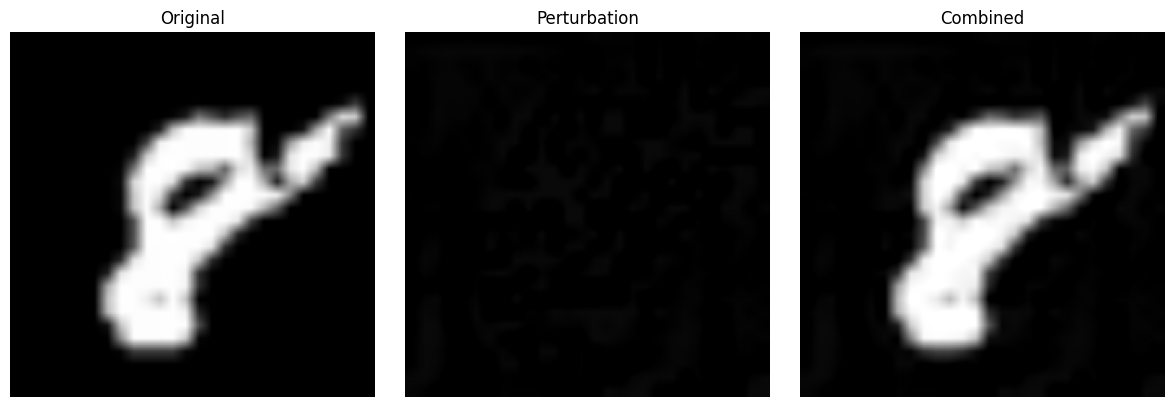

torch.Size([1, 1, 28, 28]) torch.Size([1, 3, 224, 224]) torch.Size([])
Step 0, Loss: 7.5558, Predicted: 8
Step 2, Loss: 7.5291, Predicted: 8
Step 4, Loss: 7.4999, Predicted: 8
Step 6, Loss: 7.4665, Predicted: 8
Step 8, Loss: 7.4292, Predicted: 8
Step 10, Loss: 7.3852, Predicted: 8
Step 12, Loss: 7.3332, Predicted: 8
Step 14, Loss: 7.2734, Predicted: 8
Step 16, Loss: 7.2089, Predicted: 8
Step 18, Loss: 7.1344, Predicted: 8
Step 20, Loss: 7.0558, Predicted: 8
Step 22, Loss: 6.9696, Predicted: 8
Step 24, Loss: 6.8738, Predicted: 8
Step 26, Loss: 6.7666, Predicted: 8
Step 28, Loss: 6.6430, Predicted: 8
Step 30, Loss: 6.4951, Predicted: 8
Step 32, Loss: 6.3110, Predicted: 8
Step 34, Loss: 6.0747, Predicted: 8
Step 36, Loss: 5.7606, Predicted: 8
Step 38, Loss: 5.3136, Predicted: 8
Step 40, Loss: 4.6401, Predicted: 8
Step 42, Loss: 3.6262, Predicted: 8
Step 44, Loss: 2.2427, Predicted: 8
Step 46, Loss: 0.8418, Predicted: 8
SUCCESS!!!! 3
0.00071839767


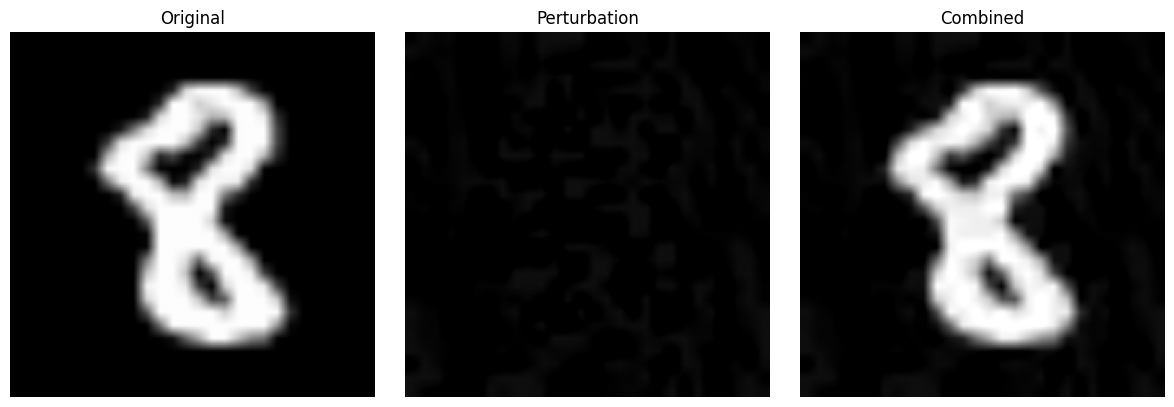

torch.Size([1, 1, 28, 28]) torch.Size([1, 3, 224, 224]) torch.Size([])
Step 0, Loss: 7.9822, Predicted: 3
Step 2, Loss: 7.9646, Predicted: 3
Step 4, Loss: 7.9439, Predicted: 3
Step 6, Loss: 7.9206, Predicted: 3
Step 8, Loss: 7.8961, Predicted: 3
Step 10, Loss: 7.8693, Predicted: 3
Step 12, Loss: 7.8399, Predicted: 3
Step 14, Loss: 7.8093, Predicted: 3
Step 16, Loss: 7.7776, Predicted: 3
Step 18, Loss: 7.7441, Predicted: 3
Step 20, Loss: 7.7085, Predicted: 3
Step 22, Loss: 7.6707, Predicted: 3
Step 24, Loss: 7.6299, Predicted: 3
Step 26, Loss: 7.5857, Predicted: 3
Step 28, Loss: 7.5372, Predicted: 3
Step 30, Loss: 7.4834, Predicted: 3
Step 32, Loss: 7.4230, Predicted: 3
Step 34, Loss: 7.3554, Predicted: 3
Step 36, Loss: 7.2757, Predicted: 3
Step 38, Loss: 7.1869, Predicted: 3
Step 40, Loss: 7.0823, Predicted: 3
Step 42, Loss: 6.9597, Predicted: 3
Step 44, Loss: 6.8152, Predicted: 3
Step 46, Loss: 6.6483, Predicted: 3
Step 48, Loss: 6.4463, Predicted: 3
Step 50, Loss: 6.2006, Predicted: 

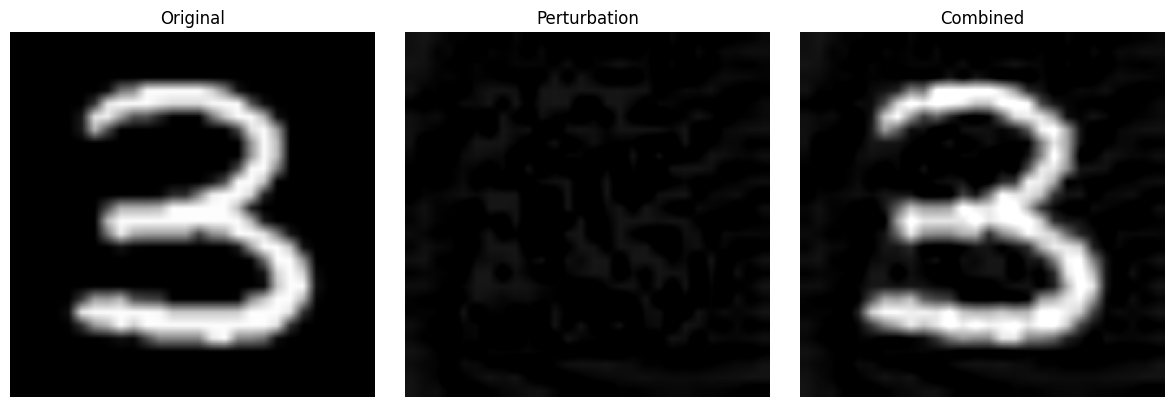

torch.Size([1, 1, 28, 28]) torch.Size([1, 3, 224, 224]) torch.Size([])
Step 0, Loss: 7.6532, Predicted: 3
Step 2, Loss: 7.6154, Predicted: 3
Step 4, Loss: 7.5735, Predicted: 3
Step 6, Loss: 7.5268, Predicted: 3
Step 8, Loss: 7.4737, Predicted: 3
Step 10, Loss: 7.4137, Predicted: 3
Step 12, Loss: 7.3468, Predicted: 3
Step 14, Loss: 7.2722, Predicted: 3
Step 16, Loss: 7.1886, Predicted: 3
Step 18, Loss: 7.0948, Predicted: 3
Step 20, Loss: 6.9891, Predicted: 3
Step 22, Loss: 6.8705, Predicted: 3
Step 24, Loss: 6.7369, Predicted: 3
Step 26, Loss: 6.5851, Predicted: 3
Step 28, Loss: 6.4124, Predicted: 3
Step 30, Loss: 6.2170, Predicted: 3
Step 32, Loss: 5.9938, Predicted: 3
Step 34, Loss: 5.7371, Predicted: 3
Step 36, Loss: 5.4361, Predicted: 3
Step 38, Loss: 5.0805, Predicted: 3
Step 40, Loss: 4.6510, Predicted: 3
Step 42, Loss: 4.1217, Predicted: 3
Step 44, Loss: 3.4853, Predicted: 3
Step 46, Loss: 2.7314, Predicted: 3
Step 48, Loss: 1.8699, Predicted: 3
Step 50, Loss: 1.0312, Predicted: 

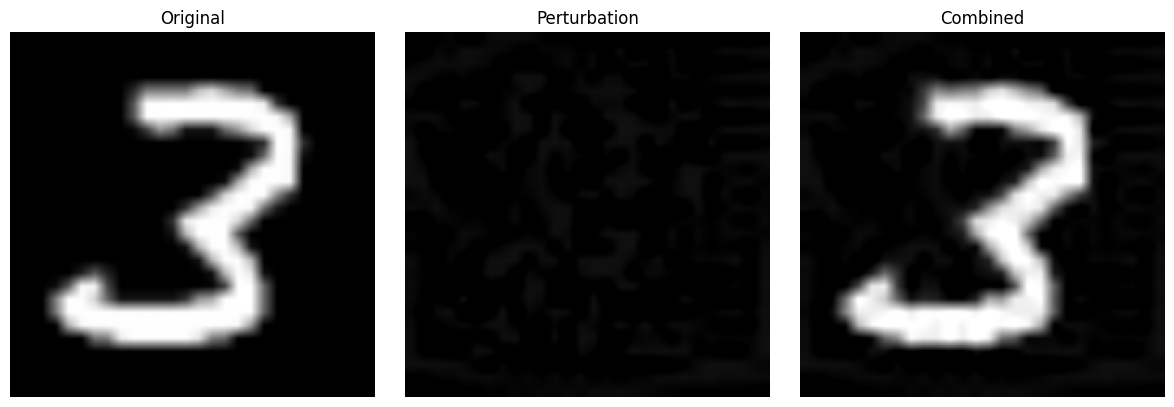

In [42]:
for parameter in model.parameters():
    parameter.requires_grad = False

means = []

for i in range(50):
    num_epochs = 10000
    l2_reg = 0.2

    perturbation = torch.randn((1, 1,28,28)) * 1e-5
    perturbation.requires_grad = True


    Xb, yb = train_dataset[i]
    Xb = Xb.unsqueeze(0)
    print(perturbation.size(), Xb.size(), yb.size())
    original_class = yb.item()
    target_class_id = 8 if original_class == 3  else 3

    target_class_tensor = torch.tensor([target_class_id], dtype=torch.long, device=device)
    # target_class_tensor
    # Optimizer for the perturbation
    l2_reg = 5.0
    lr = 1e-3
    steps = 1000
    optimizer = torch.optim.Adam([perturbation], lr=lr)

    success = False
    for step in range(steps):
        optimizer.zero_grad()

        # with torch.no_grad():
            # Repeat the channel dimension 3 times: (N, 1, 28, 28) -> (N, 3, 28, 28)
        perturbation2 = perturbation.repeat(1, 3, 1, 1)
        perturbation2 = resize_transform(perturbation2)
        # Apply perturbation
        perturbed_inputs = torch.clamp(Xb + perturbation2, 0, 1)

        # Get model predictions
        outputs = model(pixel_values=perturbed_inputs)
        logits = outputs.logits

        # Compute loss (cross-entropy with target class)
        loss = torch.nn.functional.cross_entropy(logits, target_class_tensor)

        l2_loss = perturbation.norm()
        total_loss = loss + l2_reg * l2_loss

        # Check if attack succeeded
        predicted_class = logits.argmax(-1).item()
        if predicted_class == target_class_id:
            print(f"SUCCESS!!!! {predicted_class}")
            success = True
            break

        # Backward pass
        loss.backward()
        optimizer.step()

        if step % 2 == 0:
            print(f'Step {step}, Loss: {loss.item():.4f}, Predicted: {model.config.id2label[predicted_class]}')

    Xb_np = Xb.detach().numpy()[0][0]
    perturbation2 = resize_transform(perturbation)
    perturbation_np = perturbation2.detach().numpy()[0][0]

    means.append(np.mean(perturbation_np.reshape(-1) ** 2))
    print(means[-1])
    import matplotlib.pyplot as plt

    # Create a row of 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    # Original
    axes[0].imshow(Xb_np, cmap="gray", vmin=0, vmax=1)
    axes[0].set_title("Original")
    axes[0].axis("off")

    # Perturbation
    axes[1].imshow(perturbation_np, cmap="gray", vmin=0, vmax=1)
    axes[1].set_title("Perturbation")
    axes[1].axis("off")

    # Combined
    axes[2].imshow(Xb_np + perturbation_np, cmap="gray", vmin=0, vmax=1)
    axes[2].set_title("Combined")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

In [44]:
np.mean(means)

0.0008915822